<table class="table table-bordered">
    <tr>
        <th style="text-align:center; vertical-align: middle; width:50%"><img src='https://www.np.edu.sg/images/default-source/default-album/img-logo.png'"></th>
        <th style="text-align:center;"><h1>Deep Learning</h1><h2>Assignment - Food Classification Model (Individual)</h2><h3>AY2024/25 Semester</h3></th>
    </tr>
</table>

In [1]:
# Import the Required Packages
import tensorflow as tf

from tensorflow import keras
from keras import layers
from keras import models
from keras import optimizers
from tensorflow.keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

# from tensorflow.keras import layers
# from tensorflow.keras import models
# from tensorflow.keras import optimizers
# from tensorflow.keras.preprocessing import image
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

import visualkeras

# For plotting the Training and Validation Accuracy & Loss Scores
import matplotlib.pyplot as plt
import numpy as np

import os
import datetime
import zipfile
import random

%matplotlib inline

print('tensorflow: ', tf.__version__)
print('keras: ', keras.__version__)

tensorflow:  2.10.1
keras:  2.10.0


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## Step 1: Data Loading

In [3]:
import os
# path to your downloaded file
# base_dir = 'D:\\Practical\\DLIR\\Week_2\\cats_and_dogs_small\\'
base_dir = 'D:\\Users\\ng_a\\My NP SDGAI\\PDC-2\\DLIR\\Assignment\\data\\food\\'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

## Parameters

In [4]:
# We will resize all the images as 150*150 pixels
img_size = 150
batch_size = 64
num_classes = 10
# epochs = 20
epochs = 30

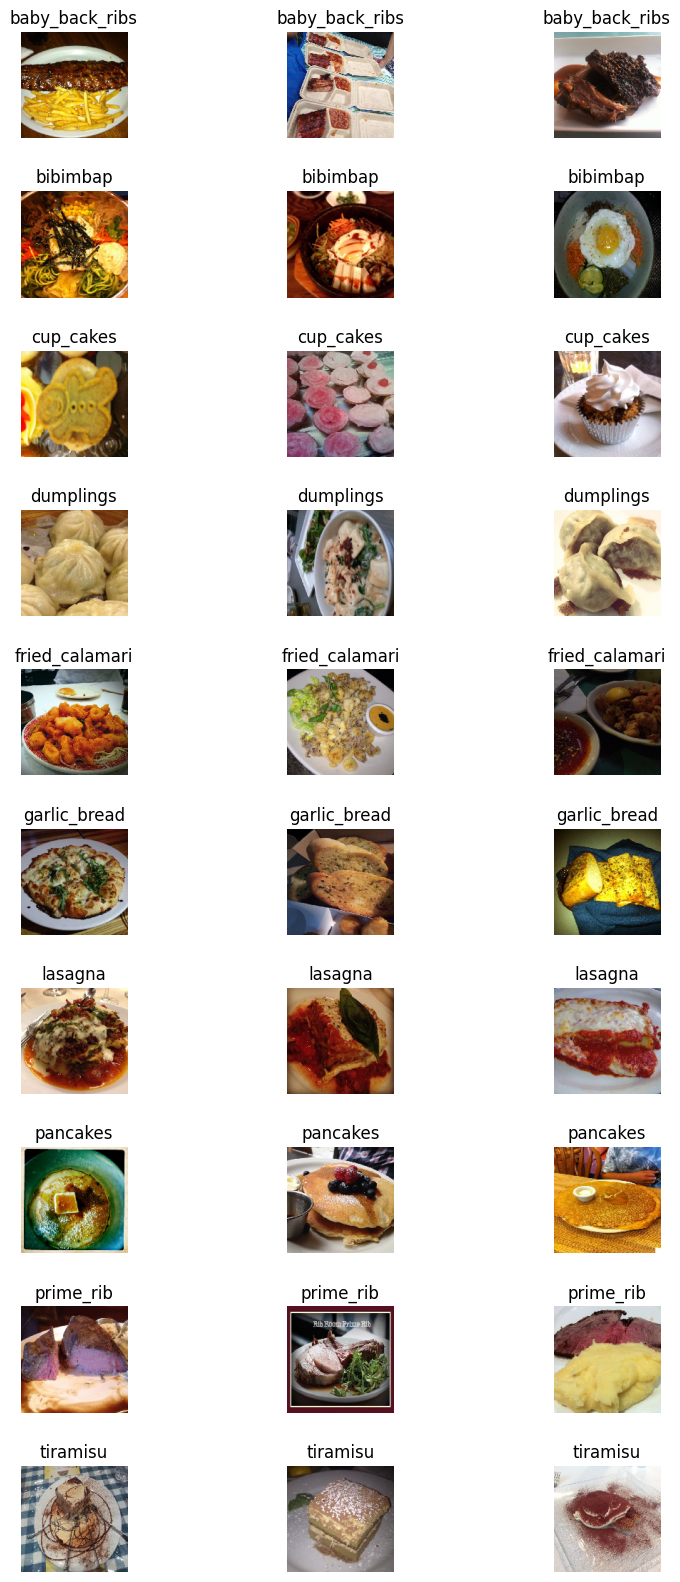

In [5]:
# Function to randomly display images from each food type
def display_random_images_from_each_food_type(dataset_path, images_per_type=3):
    images = []
    labels = []

    # Iterate through each food type directory
    for label in os.listdir(dataset_path):
        label_path = os.path.join(dataset_path, label)
        if os.path.isdir(label_path):
            img_files = os.listdir(label_path)
            sampled_files = random.sample(img_files, images_per_type)  # Randomly sample images

            for img_file in sampled_files:
                img_path = os.path.join(label_path, img_file)
                img = image.load_img(img_path, target_size=(150, 150))
                img_array = image.img_to_array(img)
                images.append(img_array)
                labels.append(label)

    # Convert to numpy arrays
    images = np.array(images)
    labels = np.array(labels)

    # Display images
    num_food_types = len(os.listdir(dataset_path))
    fig, axes = plt.subplots(num_food_types, images_per_type, figsize=(10, 20))

    for i, (img, label) in enumerate(zip(images, labels)):
        row = i // images_per_type
        col = i % images_per_type
        axes[row, col].imshow(img.astype('uint8'))
        axes[row, col].set_title(label)
        axes[row, col].axis('off')

    # Adjust spacing between subplots
    plt.subplots_adjust(wspace=0.1, hspace=0.5)
    
    plt.show()

# Example usage
dataset_path = train_dir
display_random_images_from_each_food_type(dataset_path)

## No data augmentation

In [6]:
train_datagen_no_aug = ImageDataGenerator(rescale=1./255)
test_datagen_no_aug = ImageDataGenerator(rescale=1./255)

train_generator_no_aug = train_datagen_no_aug.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(img_size, img_size),
        batch_size=batch_size,
        # For a multi-class classification problem
        class_mode='categorical')

validation_generator_no_aug = test_datagen_no_aug.flow_from_directory(
        validation_dir,
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='categorical')

Found 7500 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.


In [7]:
for data_batch, labels_batch in train_generator_no_aug:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (64, 150, 150, 3)
labels batch shape: (64, 10)


## With Data Augmentation

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen_1 = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

val_datagen_1 = ImageDataGenerator(rescale=1./255)
test_datagen_1 = ImageDataGenerator(rescale=1./255)

train_generator_1 = train_datagen_1.flow_from_directory(
    # This is the target directory
    train_dir,
    # All images will be resized to 150x150
    target_size=(img_size, img_size),
    batch_size=batch_size,
    # multi-class classification problem
    class_mode='categorical')

validation_generator_1 = val_datagen_1.flow_from_directory(
    validation_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical')

test_generator_1 = test_datagen_1.flow_from_directory(
    test_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

Found 7500 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
Found 500 images belonging to 10 classes.


In [9]:
for data_batch, labels_batch in train_generator_1:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (64, 150, 150, 3)
labels batch shape: (64, 10)


## Step 2:  Develop the Image Classification Models

In [10]:
def plot_eval_curves(my_history, which_model):
    acc = my_history.history['accuracy']
    val_acc = my_history.history['val_accuracy']
    loss = my_history.history['loss']
    val_loss = my_history.history['val_loss']

    epochs_ = range(1,len(acc)+1)

    plt.plot(epochs_, acc, 'bo', label='Training acc')
    plt.plot(epochs_, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy' + ' - ' + which_model)
    plt.legend()
    
    filename_acc = datetime.datetime.now().strftime('%d-%m-%y-%H_%M_train_val_accuracy.png')
    plt.savefig(filename_acc)
    
    plt.figure()

    plt.plot(epochs_, loss, 'bo', label='Training loss')
    plt.plot(epochs_, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss' + ' - ' + which_model)
    plt.legend()
    
    filename_loss = datetime.datetime.now().strftime('%d-%m-%y-%H_%M_train_val_loss.png')
    plt.savefig(filename_loss) 
    
    plt.show()

### Model 1 - Baseline - No Augmentation

In [11]:
model_1_bl_noaug = models.Sequential()

model_1_bl_noaug.add(keras.Input(shape=(img_size, img_size, 3)))
model_1_bl_noaug.add(layers.Conv2D(32, (3, 3), activation='relu'))
model_1_bl_noaug.add(layers.MaxPooling2D((2, 2)))
model_1_bl_noaug.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_1_bl_noaug.add(layers.MaxPooling2D((2, 2)))
model_1_bl_noaug.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_1_bl_noaug.add(layers.MaxPooling2D((2, 2)))
model_1_bl_noaug.add(layers.Conv2D(256, (3, 3), activation='relu'))
model_1_bl_noaug.add(layers.MaxPooling2D((2, 2)))
model_1_bl_noaug.add(layers.Flatten())
model_1_bl_noaug.add(layers.Dense(1024, activation='relu'))
model_1_bl_noaug.add(layers.Dense(512, activation='relu'))
model_1_bl_noaug.add(layers.Dense(num_classes, activation='softmax'))

model_1_bl_noaug.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

In [12]:
model_1_bl_noaug.compile(optimizer='adam',
              loss='categorical_crossentropy', # Used for multi-class classification
              metrics=['accuracy'])

In [13]:
# history_1_bl_noaug = model_1_bl_noaug.fit(
#     train_generator_1,
#     steps_per_epoch=train_generator_1.samples // batch_size,
#     epochs = epochs,
#     validation_data=validation_generator_1,
#     validation_steps=validation_generator_1.samples // batch_size,
#     verbose=1
# )

history_1_bl_noaug = model_1_bl_noaug.fit(
    train_generator_no_aug,
    epochs = epochs,
    validation_data=validation_generator_no_aug,
    verbose=1
)

Epoch 1/30
118/118 [==============================] - 343s 3s/step - loss: 2.0800 - accuracy: 0.2361 - val_loss: 1.8933 - val_accuracy: 0.3410
Epoch 2/30
118/118 [==============================] - 15s 131ms/step - loss: 1.7191 - accuracy: 0.3980 - val_loss: 1.6995 - val_accuracy: 0.4190
Epoch 3/30
118/118 [==============================] - 16s 135ms/step - loss: 1.5023 - accuracy: 0.4768 - val_loss: 1.5968 - val_accuracy: 0.4595
Epoch 4/30
118/118 [==============================] - 16s 133ms/step - loss: 1.3442 - accuracy: 0.5365 - val_loss: 1.5582 - val_accuracy: 0.4820
Epoch 5/30
118/118 [==============================] - 17s 142ms/step - loss: 1.1247 - accuracy: 0.6185 - val_loss: 1.4962 - val_accuracy: 0.4970
Epoch 6/30
118/118 [==============================] - 16s 134ms/step - loss: 0.8589 - accuracy: 0.7089 - val_loss: 1.6317 - val_accuracy: 0.5190
Epoch 7/30
118/118 [==============================] - 17s 146ms/step - loss: 0.5966 - accuracy: 0.7963 - val_loss: 1.8266 - val_accu

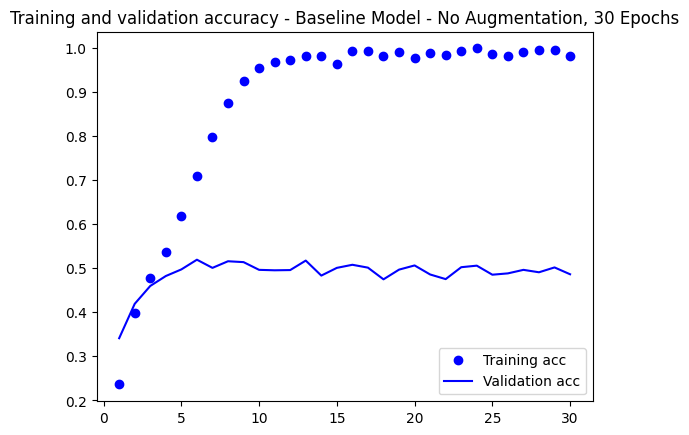

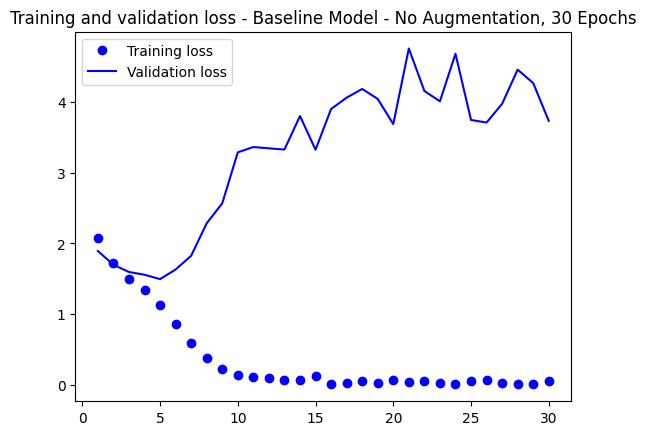

In [14]:
plot_eval_curves(history_1_bl_noaug, 'Baseline Model - No Augmentation, 30 Epochs')

In [50]:
# test_loss, test_acc = model_1__bl_noaug.evaluate(test_generator_1, steps=test_generator.samples // batch_size)
test_loss_m1_bl_noaug, test_acc_m1_bl_noaug = model_1_bl_noaug.evaluate(validation_generator_no_aug, steps=validation_generator_no_aug.samples // batch_size)
print(f'Test accuracy: {test_acc_m1_bl_noaug * 100:.2f}%')
print(f'Test Loss: {test_loss_m1_bl_noaug}')

31/31 [==============================] - 3s 101ms/step - loss: 3.7442 - accuracy: 0.4844
Test accuracy: 48.44%
Test Loss: 3.7441864013671875


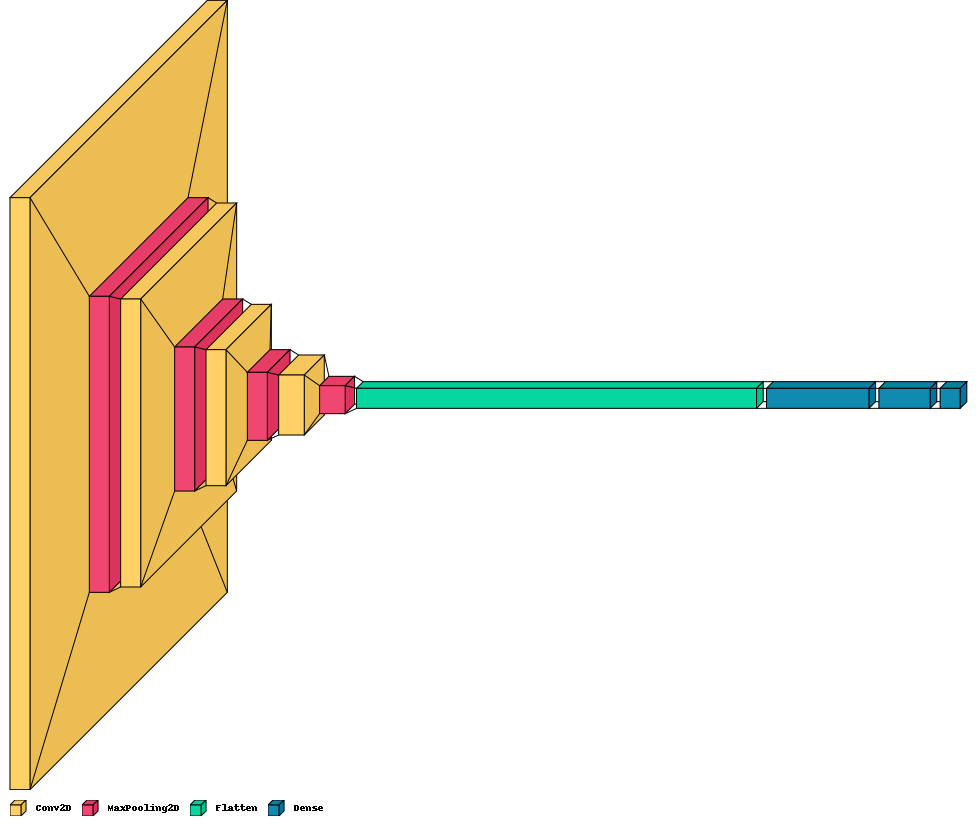

In [16]:
visualkeras.layered_view(model_1_bl_noaug, legend=True, to_file='custom_model_1.png')
visualkeras.layered_view(model_1_bl_noaug, legend=True)

### Model 1 - Baseline - With Augmentation - Epochs 20

In [17]:
model_1_bl_20 = models.Sequential()

model_1_bl_20.add(keras.Input(shape=(img_size, img_size, 3)))
model_1_bl_20.add(layers.Conv2D(32, (3, 3), activation='relu'))
model_1_bl_20.add(layers.MaxPooling2D((2, 2)))
model_1_bl_20.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_1_bl_20.add(layers.MaxPooling2D((2, 2)))
model_1_bl_20.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_1_bl_20.add(layers.MaxPooling2D((2, 2)))
model_1_bl_20.add(layers.Conv2D(256, (3, 3), activation='relu'))
model_1_bl_20.add(layers.MaxPooling2D((2, 2)))
model_1_bl_20.add(layers.Flatten())
model_1_bl_20.add(layers.Dense(1024, activation='relu'))
model_1_bl_20.add(layers.Dense(512, activation='relu'))
model_1_bl_20.add(layers.Dense(num_classes, activation='softmax'))

model_1_bl_20.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 17, 17, 128)     

In [18]:
model_1_bl_20.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [19]:
n_epochs = 20
history_1_bl_20 = model_1_bl_20.fit(
    train_generator_1,
    validation_data = validation_generator_1,
    epochs = n_epochs
)

Epoch 1/20
118/118 [==============================] - 45s 372ms/step - loss: 2.1611 - accuracy: 0.1984 - val_loss: 2.0499 - val_accuracy: 0.2735
Epoch 2/20
118/118 [==============================] - 43s 363ms/step - loss: 1.9669 - accuracy: 0.2979 - val_loss: 1.8691 - val_accuracy: 0.3335
Epoch 3/20
118/118 [==============================] - 44s 372ms/step - loss: 1.8336 - accuracy: 0.3599 - val_loss: 1.9310 - val_accuracy: 0.3475
Epoch 4/20
118/118 [==============================] - 43s 362ms/step - loss: 1.7518 - accuracy: 0.3895 - val_loss: 1.6878 - val_accuracy: 0.4065
Epoch 5/20
118/118 [==============================] - 43s 364ms/step - loss: 1.6612 - accuracy: 0.4260 - val_loss: 1.6865 - val_accuracy: 0.4285
Epoch 6/20
118/118 [==============================] - 42s 353ms/step - loss: 1.5885 - accuracy: 0.4632 - val_loss: 1.8304 - val_accuracy: 0.3955
Epoch 7/20
118/118 [==============================] - 44s 373ms/step - loss: 1.5182 - accuracy: 0.4780 - val_loss: 1.6149 - val_ac

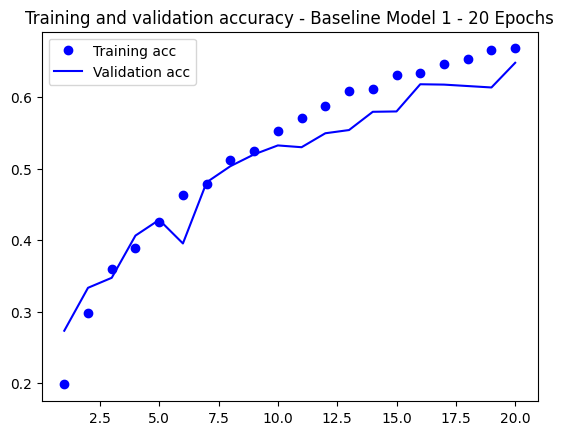

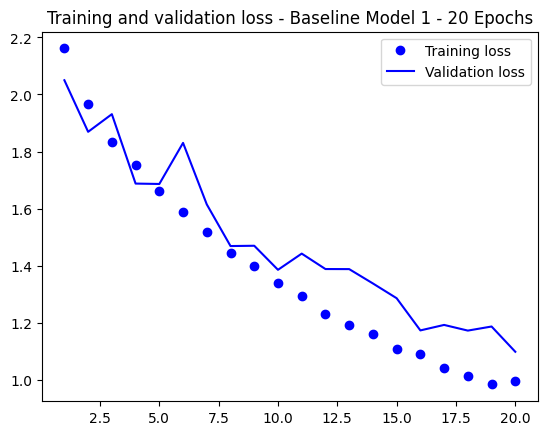

In [20]:
plot_eval_curves(history_1_bl_20, 'Baseline Model 1 - 20 Epochs')

In [51]:
test_loss_m1_bl_20, test_acc_m1_bl_20 = model_1_bl_20.evaluate(test_generator_1, steps=test_generator_1.samples // batch_size)
print(f'Test accuracy: {test_acc_m1_bl_20 * 100:.2f}%')
print(f'Test Loss: {test_loss_m1_bl_20}')

7/7 [==============================] - 1s 85ms/step - loss: 0.9791 - accuracy: 0.6719
Test accuracy: 67.19%
Test Loss: 0.9791046380996704


### Model 1 - Baseline - With Augmentation - Epochs 30 (Scale Up)

In [22]:
# Build the Model

model_1_bl_30 = models.Sequential()

model_1_bl_30.add(keras.Input(shape=(img_size, img_size, 3)))
model_1_bl_30.add(layers.Conv2D(32, (3, 3), activation='relu'))
model_1_bl_30.add(layers.MaxPooling2D((2, 2)))
model_1_bl_30.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_1_bl_30.add(layers.MaxPooling2D((2, 2)))
model_1_bl_30.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_1_bl_30.add(layers.MaxPooling2D((2, 2)))
model_1_bl_30.add(layers.Conv2D(256, (3, 3), activation='relu'))
model_1_bl_30.add(layers.MaxPooling2D((2, 2)))
model_1_bl_30.add(layers.Flatten())
model_1_bl_30.add(layers.Dense(1024, activation='relu'))
model_1_bl_30.add(layers.Dense(512, activation='relu'))
model_1_bl_30.add(layers.Dense(num_classes, activation='softmax'))

model_1_bl_30.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 17, 17, 128)     

In [23]:
# Compile the model

# Since this is a multi-class, single-label prediction, we use categorical_crossentropy as the loss function 
# and softmax as the final activation function.
model_1_bl_30.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [24]:
# Train the Model
# history_1 = model_1.fit(
#     train_generator,
#     steps_per_epoch = train_generator.samples // batch_size,
#     validation_data = validation_generator,
#     validation_steps = validation_generator.samples // batch_size,
#     epochs = epochs
# )

history_1_bl_30 = model_1_bl_30.fit(
    train_generator_1,
    validation_data = validation_generator_1,
    epochs = epochs
)

Epoch 1/30
118/118 [==============================] - 41s 343ms/step - loss: 2.1824 - accuracy: 0.1824 - val_loss: 2.0293 - val_accuracy: 0.2650
Epoch 2/30
118/118 [==============================] - 41s 343ms/step - loss: 1.9672 - accuracy: 0.2988 - val_loss: 1.9550 - val_accuracy: 0.3135
Epoch 3/30
118/118 [==============================] - 43s 361ms/step - loss: 1.8564 - accuracy: 0.3577 - val_loss: 1.8452 - val_accuracy: 0.3435
Epoch 4/30
118/118 [==============================] - 40s 335ms/step - loss: 1.7548 - accuracy: 0.3848 - val_loss: 1.7030 - val_accuracy: 0.4105
Epoch 5/30
118/118 [==============================] - 40s 339ms/step - loss: 1.6771 - accuracy: 0.4144 - val_loss: 1.6345 - val_accuracy: 0.4380
Epoch 6/30
118/118 [==============================] - 41s 343ms/step - loss: 1.6027 - accuracy: 0.4351 - val_loss: 1.7398 - val_accuracy: 0.4195
Epoch 7/30
118/118 [==============================] - 43s 363ms/step - loss: 1.5320 - accuracy: 0.4647 - val_loss: 1.6756 - val_ac

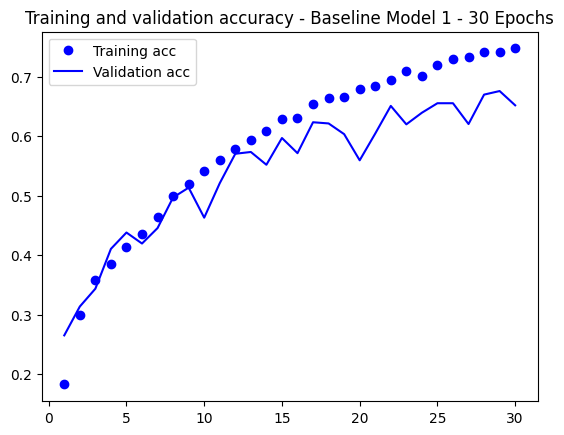

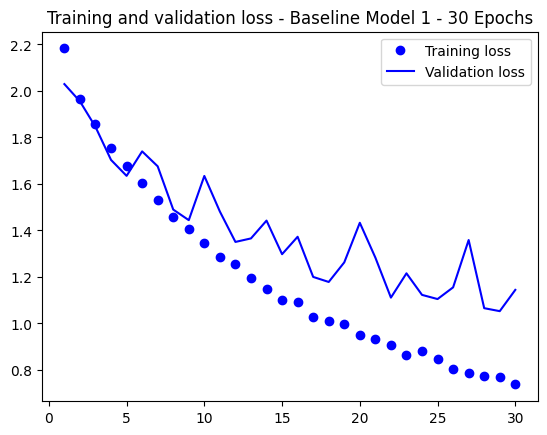

In [25]:
plot_eval_curves(history_1_bl_30, 'Baseline Model 1 - 30 Epochs')

In [52]:
test_loss_m1_bl_30, test_acc_m1_bl_30 = model_1_bl_30.evaluate(test_generator_1, steps=test_generator_1.samples // batch_size)
print(f'Test accuracy: {test_acc_m1_bl_30 * 100:.2f}%')
print(f'Test Loss: {test_loss_m1_bl_30}')

7/7 [==============================] - 1s 83ms/step - loss: 1.0436 - accuracy: 0.6652
Test accuracy: 66.52%
Test Loss: 1.0435582399368286


## Handling Overfitting

### Regularization using L2 with regularization factor 0.001

In [27]:
n_epochs = 30

In [28]:
# from tensorflow.keras import regularizers
from keras import regularizers

model_1_wr = models.Sequential()

model_1_wr.add(keras.Input(shape=(img_size, img_size, 3)))
model_1_wr.add(layers.Conv2D(32, (3, 3), activation='relu'))
model_1_wr.add(layers.MaxPooling2D((2, 2)))
model_1_wr.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_1_wr.add(layers.MaxPooling2D((2, 2)))
model_1_wr.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_1_wr.add(layers.MaxPooling2D((2, 2)))
model_1_wr.add(layers.Conv2D(256, (3, 3), activation='relu'))
model_1_wr.add(layers.MaxPooling2D((2, 2)))
model_1_wr.add(layers.Flatten())
model_1_wr.add(layers.Dense(1024, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
model_1_wr.add(layers.Dense(512, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
model_1_wr.add(layers.Dense(num_classes, activation='softmax'))

model_1_wr.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 17, 17, 128)     

In [29]:
model_1_wr.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [30]:
history_1_wr = model_1_wr.fit(
    train_generator_1,
    validation_data = validation_generator_1,
    epochs = n_epochs
)

Epoch 1/30
118/118 [==============================] - 41s 341ms/step - loss: 2.5842 - accuracy: 0.1700 - val_loss: 2.4386 - val_accuracy: 0.1975
Epoch 2/30
118/118 [==============================] - 39s 331ms/step - loss: 2.0982 - accuracy: 0.2577 - val_loss: 2.0828 - val_accuracy: 0.2925
Epoch 3/30
118/118 [==============================] - 41s 345ms/step - loss: 1.9797 - accuracy: 0.3189 - val_loss: 2.3016 - val_accuracy: 0.2735
Epoch 4/30
118/118 [==============================] - 40s 336ms/step - loss: 1.8935 - accuracy: 0.3452 - val_loss: 2.1317 - val_accuracy: 0.2965
Epoch 5/30
118/118 [==============================] - 40s 335ms/step - loss: 1.8384 - accuracy: 0.3843 - val_loss: 1.8533 - val_accuracy: 0.3895
Epoch 6/30
118/118 [==============================] - 39s 328ms/step - loss: 1.7934 - accuracy: 0.3997 - val_loss: 1.7649 - val_accuracy: 0.4055
Epoch 7/30
118/118 [==============================] - 41s 350ms/step - loss: 1.7584 - accuracy: 0.4133 - val_loss: 1.7433 - val_ac

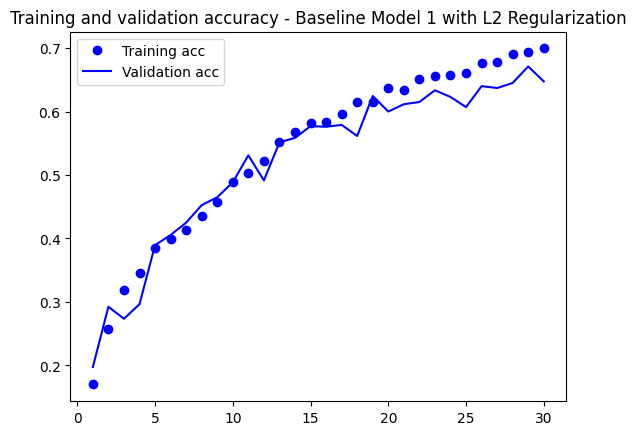

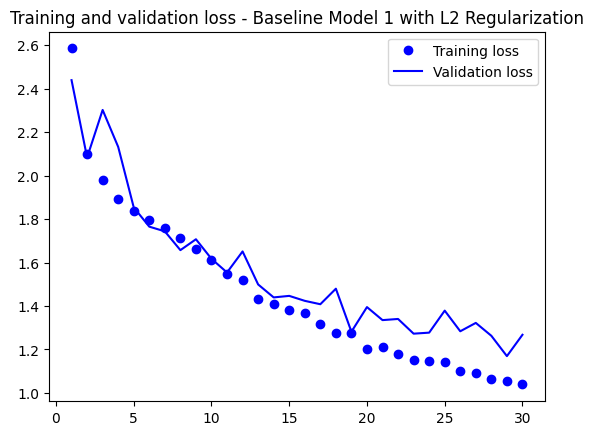

In [31]:
plot_eval_curves(history_1_wr, 'Baseline Model 1 with L2 Regularization')

In [53]:
test_loss_m1_l2_wr, test_acc_m1_l2_wr = model_1_wr.evaluate(test_generator_1, steps=test_generator_1.samples // batch_size)
print(f'Test accuracy: {test_acc_m1_l2_wr * 100:.2f}%')
print(f'Test Loss: {test_loss_m1_l2_wr}')

7/7 [==============================] - 1s 84ms/step - loss: 1.2567 - accuracy: 0.6540
Test accuracy: 65.40%
Test Loss: 1.2567251920700073


### Regularization using L1 & L2 with regularization factor 0.001

In [33]:
model_1_wr_l1_l2 = models.Sequential()

model_1_wr_l1_l2.add(keras.Input(shape=(img_size, img_size, 3)))
model_1_wr_l1_l2.add(layers.Conv2D(32, (3, 3), activation='relu'))
model_1_wr_l1_l2.add(layers.MaxPooling2D((2, 2)))
model_1_wr_l1_l2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_1_wr_l1_l2.add(layers.MaxPooling2D((2, 2)))
model_1_wr_l1_l2.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_1_wr_l1_l2.add(layers.MaxPooling2D((2, 2)))
model_1_wr_l1_l2.add(layers.Conv2D(256, (3, 3), activation='relu'))
model_1_wr_l1_l2.add(layers.MaxPooling2D((2, 2)))
model_1_wr_l1_l2.add(layers.Flatten())
model_1_wr_l1_l2.add(layers.Dense(1024, kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001), activation='relu'))
model_1_wr_l1_l2.add(layers.Dense(512, kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001), activation='relu'))
model_1_wr_l1_l2.add(layers.Dense(num_classes, activation='softmax'))

model_1_wr_l1_l2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 17, 17, 128)     

In [34]:
model_1_wr_l1_l2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [35]:
history_1_wr_l1_l2 = model_1_wr_l1_l2.fit(
    train_generator_1,
    validation_data = validation_generator_1,
    epochs = n_epochs
)

Epoch 1/30
118/118 [==============================] - 41s 344ms/step - loss: 18.3795 - accuracy: 0.1335 - val_loss: 3.8688 - val_accuracy: 0.1515
Epoch 2/30
118/118 [==============================] - 40s 336ms/step - loss: 3.8425 - accuracy: 0.1628 - val_loss: 3.8028 - val_accuracy: 0.1840
Epoch 3/30
118/118 [==============================] - 42s 358ms/step - loss: 3.7868 - accuracy: 0.1899 - val_loss: 3.7789 - val_accuracy: 0.2110
Epoch 4/30
118/118 [==============================] - 41s 348ms/step - loss: 3.7173 - accuracy: 0.2181 - val_loss: 3.6890 - val_accuracy: 0.2285
Epoch 5/30
118/118 [==============================] - 41s 347ms/step - loss: 3.6776 - accuracy: 0.2353 - val_loss: 3.6692 - val_accuracy: 0.2430
Epoch 6/30
118/118 [==============================] - 39s 331ms/step - loss: 3.6464 - accuracy: 0.2481 - val_loss: 3.6494 - val_accuracy: 0.2550
Epoch 7/30
118/118 [==============================] - 42s 357ms/step - loss: 3.5978 - accuracy: 0.2701 - val_loss: 3.5968 - val_a

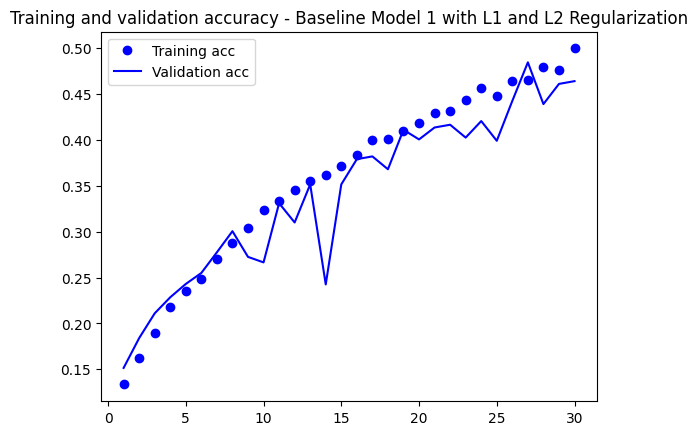

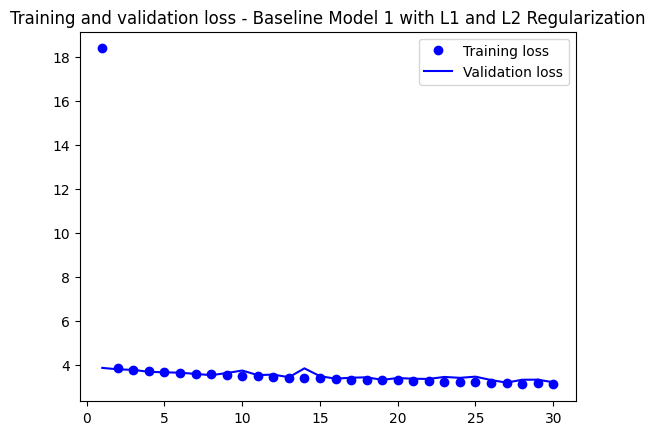

In [36]:
plot_eval_curves(history_1_wr_l1_l2, 'Baseline Model 1 with L1 and L2 Regularization')

In [54]:
test_loss_m1_l1_l2_wr, test_acc_m1_l1_l2_wr = model_1_wr_l1_l2.evaluate(test_generator_1, steps=test_generator_1.samples // batch_size)
print(f'Test accuracy: {test_acc_m1_l1_l2_wr * 100:.2f}%')
print(f'Test Loss: {test_loss_m1_l1_l2_wr}')

7/7 [==============================] - 1s 97ms/step - loss: 3.1720 - accuracy: 0.4955
Test accuracy: 49.55%
Test Loss: 3.1719553470611572


### Adding Drop Out

In [38]:
model_1_do = models.Sequential()

model_1_do.add(keras.Input(shape=(img_size, img_size, 3)))
model_1_do.add(layers.Conv2D(32, (3, 3), activation='relu'))
model_1_do.add(layers.MaxPooling2D((2, 2)))
model_1_do.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_1_do.add(layers.MaxPooling2D((2, 2)))
model_1_do.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_1_do.add(layers.MaxPooling2D((2, 2)))
model_1_do.add(layers.Conv2D(256, (3, 3), activation='relu'))
model_1_do.add(layers.MaxPooling2D((2, 2)))
model_1_do.add(layers.Flatten())
model_1_do.add(layers.Dense(1024, activation='relu'))
model_1_do.add(layers.Dropout(0.5)) # Add dropout with a rate of 0.5
model_1_do.add(layers.Dense(512, activation='relu'))
model_1_do.add(layers.Dropout(0.5)) # Add dropout with a rate of 0.5
model_1_do.add(layers.Dense(num_classes, activation='softmax'))

model_1_do.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 17, 17, 128)     

In [39]:
model_1_do.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [40]:
history_1_do = model_1_do.fit(
    train_generator_1,
    validation_data = validation_generator_1,
    epochs = n_epochs
)

Epoch 1/30
118/118 [==============================] - 41s 344ms/step - loss: 2.2192 - accuracy: 0.1708 - val_loss: 2.1090 - val_accuracy: 0.2285
Epoch 2/30
118/118 [==============================] - 40s 341ms/step - loss: 2.0601 - accuracy: 0.2551 - val_loss: 1.9538 - val_accuracy: 0.3105
Epoch 3/30
118/118 [==============================] - 41s 347ms/step - loss: 1.9377 - accuracy: 0.3104 - val_loss: 1.9515 - val_accuracy: 0.3235
Epoch 4/30
118/118 [==============================] - 40s 340ms/step - loss: 1.8616 - accuracy: 0.3425 - val_loss: 1.8934 - val_accuracy: 0.3515
Epoch 5/30
118/118 [==============================] - 43s 363ms/step - loss: 1.8000 - accuracy: 0.3737 - val_loss: 1.8189 - val_accuracy: 0.3825
Epoch 6/30
118/118 [==============================] - 40s 334ms/step - loss: 1.7166 - accuracy: 0.4053 - val_loss: 1.9587 - val_accuracy: 0.3630
Epoch 7/30
118/118 [==============================] - 42s 356ms/step - loss: 1.6781 - accuracy: 0.4217 - val_loss: 1.7266 - val_ac

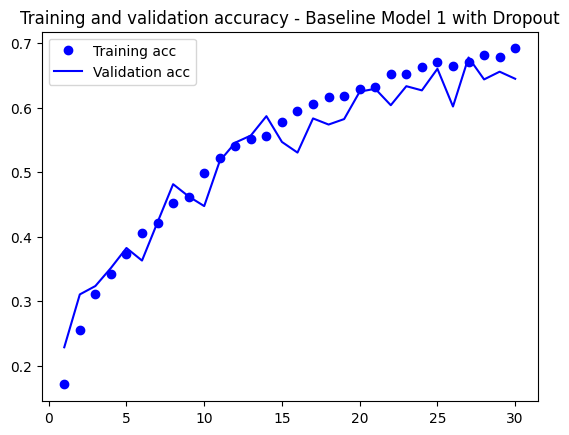

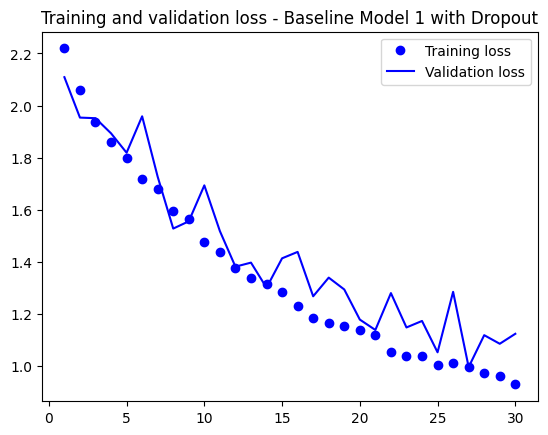

In [41]:
plot_eval_curves(history_1_do, 'Baseline Model 1 with Dropout')

In [55]:
test_loss_m1_do, test_acc_m1_do = model_1_do.evaluate(test_generator_1, steps=test_generator_1.samples // batch_size)
print(f'Test accuracy: {test_acc_m1_do * 100:.2f}%')
print(f'Test Loss: {test_loss_m1_do}')

7/7 [==============================] - 1s 84ms/step - loss: 1.1179 - accuracy: 0.6272
Test accuracy: 62.72%
Test Loss: 1.117904782295227


### Early Stopping

In [43]:
model_1_es = models.Sequential()

model_1_es.add(keras.Input(shape=(img_size, img_size, 3)))
model_1_es.add(layers.Conv2D(32, (3, 3), activation='relu'))
model_1_es.add(layers.MaxPooling2D((2, 2)))
model_1_es.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_1_es.add(layers.MaxPooling2D((2, 2)))
model_1_es.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_1_es.add(layers.MaxPooling2D((2, 2)))
model_1_es.add(layers.Conv2D(256, (3, 3), activation='relu'))
model_1_es.add(layers.MaxPooling2D((2, 2)))
model_1_es.add(layers.Flatten())
model_1_es.add(layers.Dense(1024, activation='relu'))
model_1_es.add(layers.Dense(512, activation='relu'))
model_1_es.add(layers.Dense(num_classes, activation='softmax'))

model_1_es.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 17, 17, 128)     

In [44]:
model_1_es.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [46]:
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=3)

history_1_es = model_1_es.fit(
    train_generator_1,
    validation_data = validation_generator_1,
    callbacks=[callback],
    epochs = n_epochs
)

Epoch 1/30
118/118 [==============================] - 40s 331ms/step - loss: 2.2098 - accuracy: 0.1805 - val_loss: 2.1346 - val_accuracy: 0.2325
Epoch 2/30
118/118 [==============================] - 39s 331ms/step - loss: 2.0020 - accuracy: 0.2817 - val_loss: 1.9071 - val_accuracy: 0.3300
Epoch 3/30
118/118 [==============================] - 41s 348ms/step - loss: 1.8712 - accuracy: 0.3352 - val_loss: 1.7847 - val_accuracy: 0.3640
Epoch 4/30
118/118 [==============================] - 40s 334ms/step - loss: 1.8042 - accuracy: 0.3688 - val_loss: 1.8968 - val_accuracy: 0.3535
Epoch 5/30
118/118 [==============================] - 41s 346ms/step - loss: 1.7155 - accuracy: 0.3959 - val_loss: 1.8494 - val_accuracy: 0.3830
Epoch 6/30
118/118 [==============================] - 40s 339ms/step - loss: 1.6580 - accuracy: 0.4175 - val_loss: 1.8960 - val_accuracy: 0.3840
Epoch 7/30
118/118 [==============================] - 41s 349ms/step - loss: 1.5851 - accuracy: 0.4443 - val_loss: 1.5823 - val_ac

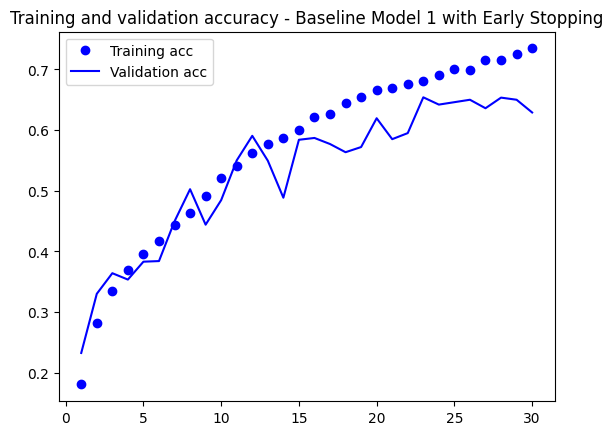

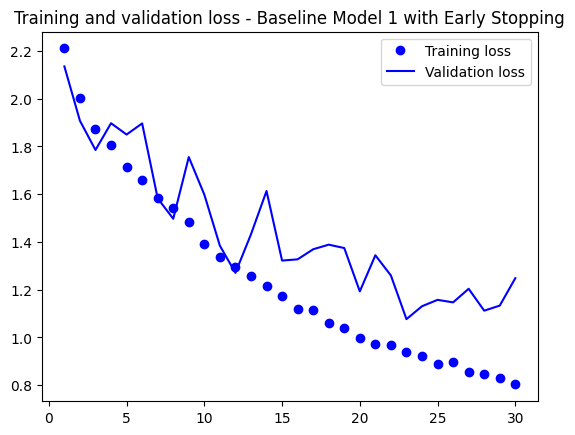

In [47]:
plot_eval_curves(history_1_es, 'Baseline Model 1 with Early Stopping')

In [57]:
test_loss_m1_es, test_acc_m1_es = model_1_es.evaluate(test_generator_1, steps=test_generator_1.samples // batch_size)
print(f'Test accuracy: {test_acc_m1_es * 100:.2f}%')
print(f'Test Loss: {test_loss_m1_es}')

7/7 [==============================] - 1s 85ms/step - loss: 1.1922 - accuracy: 0.6272
Test accuracy: 62.72%
Test Loss: 1.1922237873077393


### Result accumulator for Model 1

In [62]:
import pandas as pd

# Example data: each experiment has a test loss and test accuracy
m1_experiment_results = [
    {"experiment": "Exp1", "test_loss": test_loss_m1_bl_noaug, "test_acc": test_acc_m1_bl_noaug},
    {"experiment": "Exp2", "test_loss": test_loss_m1_bl_20, "test_acc": test_acc_m1_bl_20},
    {"experiment": "Exp3", "test_loss": test_loss_m1_bl_30, "test_acc": test_acc_m1_bl_30},
    {"experiment": "Exp4", "test_loss": test_loss_m1_l2_wr, "test_acc": test_acc_m1_l2_wr},
    {"experiment": "Exp5", "test_loss": test_loss_m1_l1_l2_wr, "test_acc": test_acc_m1_l1_l2_wr},
    {"experiment": "Exp6", "test_loss": test_loss_m1_do, "test_acc": test_acc_m1_do},
    {"experiment": "Exp7", "test_loss": test_loss_m1_es, "test_acc": test_acc_m1_es},    
]

# Create a DataFrame
m1_df = pd.DataFrame(m1_experiment_results)

# Round the entire DataFrame to 2 decimal places
m1_df = m1_df.round({"test_loss": 2, "test_acc": 2})

display(m1_df)

# Optionally, if you want to find the best experiment
best_by_acc = m1_df.loc[m1_df['test_acc'].idxmax()]
best_by_loss = m1_df.loc[m1_df['test_loss'].idxmin()]
print("\nBest by accuracy:", best_by_acc, '\n')
print("\nBest by loss:", best_by_loss, '\n')

experiment  test_loss  test_acc
0       Exp1       3.74      0.48
1       Exp2       0.98      0.67
2       Exp3       1.04      0.67
3       Exp4       1.26      0.65
4       Exp5       3.17      0.50
5       Exp6       1.12      0.63
6       Exp7       1.19      0.63


Best by accuracy: experiment    Exp2
test_loss     0.98
test_acc      0.67
Name: 1, dtype: object 


Best by loss: experiment    Exp2
test_loss     0.98
test_acc      0.67
Name: 1, dtype: object 



### Saving all Model 1 experimental models

In [49]:
# Save the Model
# filename1 = datetime.datetime.now().strftime('%d-%m-%y-%H_%M_food_model_1_do.keras')
# model_1.save('food_model_1.keras')
model_1_bl_noaug.save(datetime.datetime.now().strftime('%d-%m-%y-%H_%M_food_model_1_bl_no_aug.keras'))
model_1_bl_20.save(datetime.datetime.now().strftime('%d-%m-%y-%H_%M_food_model_1_bl_20.keras'))
model_1_bl_30.save(datetime.datetime.now().strftime('%d-%m-%y-%H_%M_food_model_1_bl_30.keras'))
model_1_wr.save(datetime.datetime.now().strftime('%d-%m-%y-%H_%M_food_model_1_lr2.keras'))
model_1_wr_l1_l2.save(datetime.datetime.now().strftime('%d-%m-%y-%H_%M_food_model_1_wr_l1_lr2.keras'))
model_1_do.save(datetime.datetime.now().strftime('%d-%m-%y-%H_%M_food_model_1_do.keras'))
model_1_es.save(datetime.datetime.now().strftime('%d-%m-%y-%H_%M_food_model_1_es.keras'))

### Model 2 - Using Pre-Trained Convnets

In [ ]:
import tensorflow as tf

from tensorflow import keras

from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

# from tensorflow.keras import layers
# from tensorflow.keras import models
# from tensorflow.keras import optimizers
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

import visualkeras

# For plotting the Training and Validation Accuracy & Loss Scores
import matplotlib.pyplot as plt

import os
import datetime

import numpy as np

%matplotlib inline
# from tensorflow.keras.applications import VGG16
# from tensorflow.keras.applications.vgg16 import preprocess_input

In [65]:
from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input

In [ ]:
# Constants and Parameters
base_dir = 'D:\\Users\\ng_a\\My NP SDGAI\\PDC-2\\DLIR\\Assignment\\data\\food\\'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# We will resize all the images as 150*150 pixels
img_size = 150
batch_size = 64
num_classes = 10
# epochs = 20
epochs = 30

In [ ]:
def plot_eval_curves(my_history, which_model):
    acc = my_history.history['accuracy']
    val_acc = my_history.history['val_accuracy']
    loss = my_history.history['loss']
    val_loss = my_history.history['val_loss']

    epochs_ = range(1,len(acc)+1)

    plt.plot(epochs_, acc, 'bo', label='Training acc')
    plt.plot(epochs_, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy' + ' - ' + which_model)
    plt.legend()
    
    filename_acc = datetime.datetime.now().strftime('%d-%m-%y-%H_%M_train_val_accuracy.png')
    plt.savefig(filename_acc)
    
    plt.figure()

    plt.plot(epochs_, loss, 'bo', label='Training loss')
    plt.plot(epochs_, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss' + ' - ' + which_model)
    plt.legend()
    
    filename_loss = datetime.datetime.now().strftime('%d-%m-%y-%H_%M_train_val_loss.png')
    plt.savefig(filename_loss) 
    
    plt.show()

In [63]:
# This function is useful for pre-processing images and extracting their features using a pre-trained model, 
# which can then be fed into other layers for further training or classification tasks.
def extract_features(directory, sample_count, conv_base, datagen):
    # The features array has a shape determined by the number of samples and the output shape 
    # of the convolutional base i.e. VGG16 layer:  block5_pool (MaxPooling2D)  (None, 4, 4, 512)
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    # Stores the labels - 10 because there are 10 classes
    labels = np.zeros(shape=(sample_count, 10))
    # This reads images from a directory, resizing them to the specified img_size, and batching 
    # them as per batch_size. The class_mode='categorical' for multi-class labels
    generator = datagen.flow_from_directory(
        directory,
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='categorical')
    # It iterates through the batches of images and labels generated by flow_from_directory
    i = 0
    for inputs_batch, labels_batch in generator:
        # For each batch, it predicts the features using the pre-trained convolutional base (conv_base) 
        # and stores these features in the features array
        features_batch = conv_base.predict(inputs_batch,verbose=0)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        # It also stores the corresponding labels in the labels array.
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        # The loop continues until it processes sample_count images, using the break statement to exit the loop 
        # since generators can yield data indefinitely.
        if i * batch_size >= sample_count:
            break
    return features, labels

#### Base Layer

In [66]:
# Load the VGG16 model, excluding the top layer
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(img_size, img_size, 3))

#### Model 2 - Feature Extraction NO Data Augmentation - Epochs = 30

In [67]:
datagen_ = ImageDataGenerator(preprocessing_function=preprocess_input)
train_features, train_labels = extract_features(train_dir, 7500, conv_base, datagen_)
validation_features, validation_labels = extract_features(validation_dir, 2000, conv_base, datagen_)
test_features, test_labels = extract_features(test_dir, 500, conv_base, datagen_)

print(train_features.shape)
print(train_labels.shape)

train_features = np.reshape(train_features, (7500, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (2000, 4 * 4 * 512))
test_features = np.reshape(test_features, (500, 4 * 4 * 512))

Found 7500 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
Found 500 images belonging to 10 classes.
(7500, 4, 4, 512)
(7500, 10)


In [68]:
model_2_no_aug = models.Sequential()
model_2_no_aug.add(keras.Input(shape=(4 * 4 * 512, ))) # the output shape of the convolutional base
model_2_no_aug.add(layers.Dense(256, activation='relu'))
model_2_no_aug.add(layers.Dropout(0.5))
model_2_no_aug.add(layers.Dense(num_classes, activation='softmax'))

model_2_no_aug.summary()

# Compile the model
model_2_no_aug.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 256)               2097408   
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_22 (Dense)            (None, 10)                2570      
                                                                 
Total params: 2,099,978
Trainable params: 2,099,978
Non-trainable params: 0
_________________________________________________________________


In [69]:
# Train the Model
history_2_no_aug = model_2_no_aug.fit(
    train_features, train_labels,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(validation_features, validation_labels),
    verbose = 1
)

Epoch 1/30
118/118 [==============================] - 1s 6ms/step - loss: 4.2470 - accuracy: 0.4443 - val_loss: 1.3339 - val_accuracy: 0.5980
Epoch 2/30
118/118 [==============================] - 0s 4ms/step - loss: 1.4641 - accuracy: 0.5700 - val_loss: 1.2257 - val_accuracy: 0.6410
Epoch 3/30
118/118 [==============================] - 0s 4ms/step - loss: 1.2720 - accuracy: 0.6215 - val_loss: 1.1590 - val_accuracy: 0.6690
Epoch 4/30
118/118 [==============================] - 0s 4ms/step - loss: 1.1423 - accuracy: 0.6547 - val_loss: 1.2850 - val_accuracy: 0.6815
Epoch 5/30
118/118 [==============================] - 1s 4ms/step - loss: 0.9936 - accuracy: 0.6875 - val_loss: 1.0649 - val_accuracy: 0.7310
Epoch 6/30
118/118 [==============================] - 1s 5ms/step - loss: 0.9227 - accuracy: 0.7148 - val_loss: 1.0743 - val_accuracy: 0.7195
Epoch 7/30
118/118 [==============================] - 1s 5ms/step - loss: 0.8624 - accuracy: 0.7297 - val_loss: 1.0030 - val_accuracy: 0.7270
Epoch 

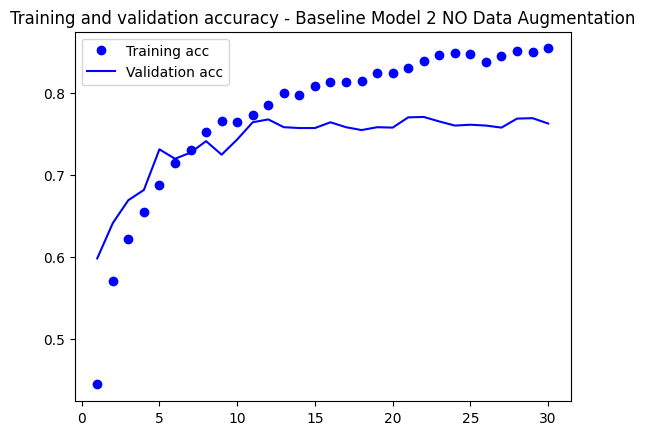

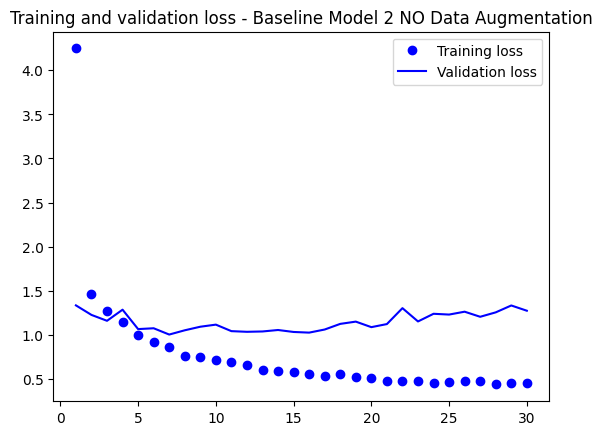

In [70]:
plot_eval_curves(history_2_no_aug, 'Baseline Model 2 NO Data Augmentation')

In [71]:
test_loss_m2_no_aug, test_acc_m2_no_aug = model_2_no_aug.evaluate(test_features, test_labels, batch_size=batch_size, verbose=1)

print(f'Test accuracy: {test_acc_m2_no_aug * 100:.2f}%')
print(f'Test Loss: {test_loss_m2_no_aug}')

8/8 [==============================] - 0s 3ms/step - loss: 1.3063 - accuracy: 0.7720
Test accuracy: 77.20%
Test Loss: 1.3063480854034424


#### Model 2 - Feature Extraction with Data Augmentation - Epochs = 30

In [72]:
train_datagen_2 = ImageDataGenerator(
      # rescale=1./255, # Handled by preprocess_input hence no need to rescale
      preprocessing_function=preprocess_input,
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
# test_datagen = ImageDataGenerator(rescale=1./255)
test_datagen_2 = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator_2 = train_datagen_2.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(img_size, img_size),
        batch_size=batch_size,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='categorical')

validation_generator_2 = test_datagen_2.flow_from_directory(
        validation_dir,
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='categorical')

test_generator_2 = test_datagen_2.flow_from_directory(
        test_dir,
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='categorical')

Found 7500 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
Found 500 images belonging to 10 classes.


In [73]:
# Build the Model

# Load the VGG16 model, excluding the top layer
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(img_size, img_size, 3))

#  Freeze base model
# to prevent any adjustment to the pre-trained weights of vgg16
conv_base.trainable = False

model_2_aug_30 = models.Sequential()

# load in the layers found in vgg16
for layer in conv_base.layers:
    model_2_aug_30.add(layer)
    
model_2_aug_30.add(layers.Flatten())
model_2_aug_30.add(layers.Dense(512, activation='relu'))
model_2_aug_30.add(layers.Dense(num_classes, activation='softmax'))

model_2_aug_30.summary()

# Compile the model
model_2_aug_30.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 37, 37, 256)      

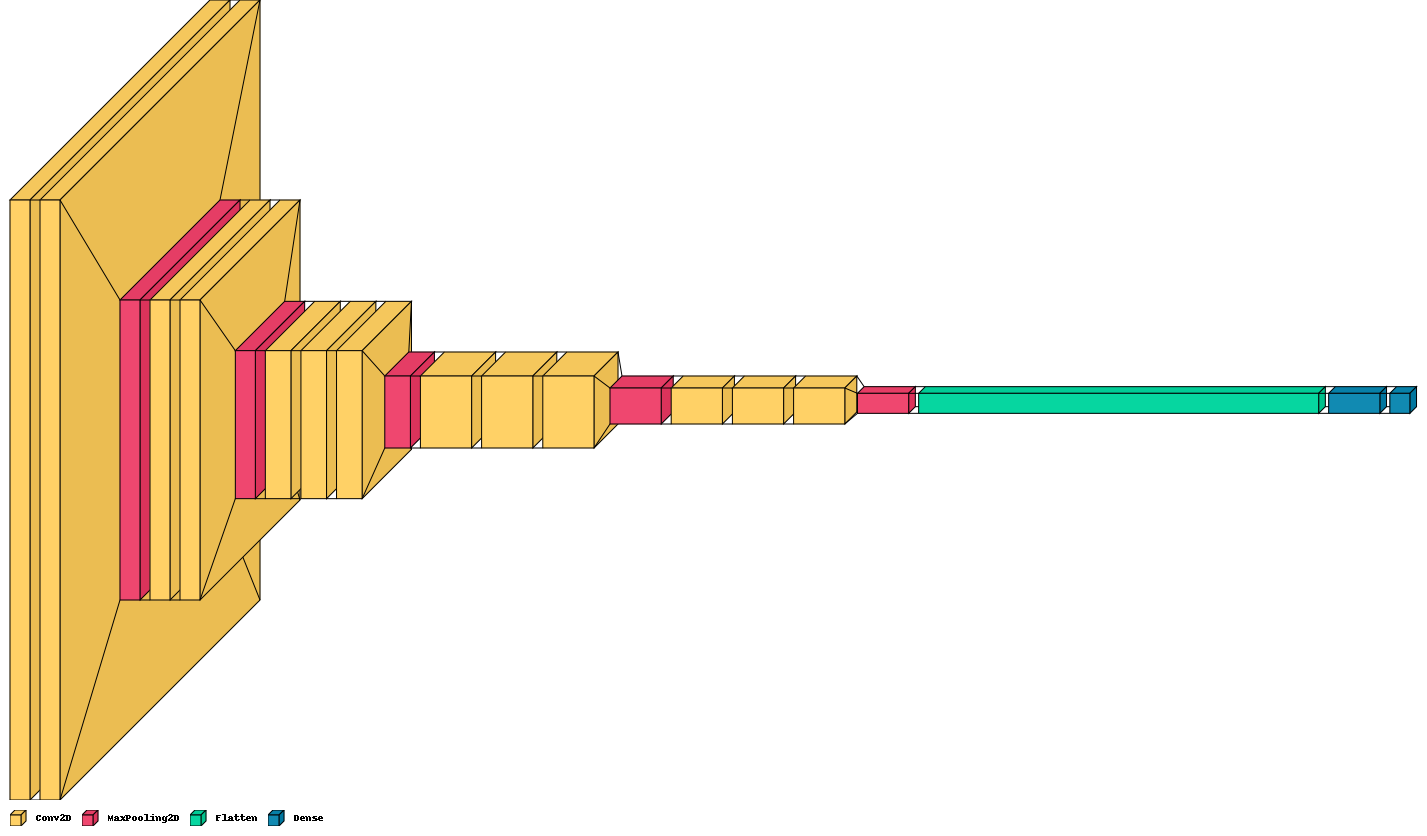

In [74]:
visualkeras.layered_view(model_2_aug_30, legend=True, to_file='pretrained_base_model_2.png')
visualkeras.layered_view(model_2_aug_30, legend=True)

In [75]:
# Train the Model
history_2_aug_30 = model_2_aug_30.fit(
    train_generator_2,
    validation_data = validation_generator_2,
    epochs = epochs,
    verbose=1
)

Epoch 1/30
118/118 [==============================] - 48s 367ms/step - loss: 7.4436 - accuracy: 0.5404 - val_loss: 1.0710 - val_accuracy: 0.6795
Epoch 2/30
118/118 [==============================] - 45s 380ms/step - loss: 1.0401 - accuracy: 0.6805 - val_loss: 1.0303 - val_accuracy: 0.7170
Epoch 3/30
118/118 [==============================] - 47s 393ms/step - loss: 0.9153 - accuracy: 0.7177 - val_loss: 0.9445 - val_accuracy: 0.7430
Epoch 4/30
118/118 [==============================] - 46s 387ms/step - loss: 0.8143 - accuracy: 0.7472 - val_loss: 0.9073 - val_accuracy: 0.7615
Epoch 5/30
118/118 [==============================] - 47s 399ms/step - loss: 0.7481 - accuracy: 0.7695 - val_loss: 0.8640 - val_accuracy: 0.7650
Epoch 6/30
118/118 [==============================] - 46s 391ms/step - loss: 0.7028 - accuracy: 0.7799 - val_loss: 0.8141 - val_accuracy: 0.7880
Epoch 7/30
118/118 [==============================] - 47s 396ms/step - loss: 0.6670 - accuracy: 0.7935 - val_loss: 0.8156 - val_ac

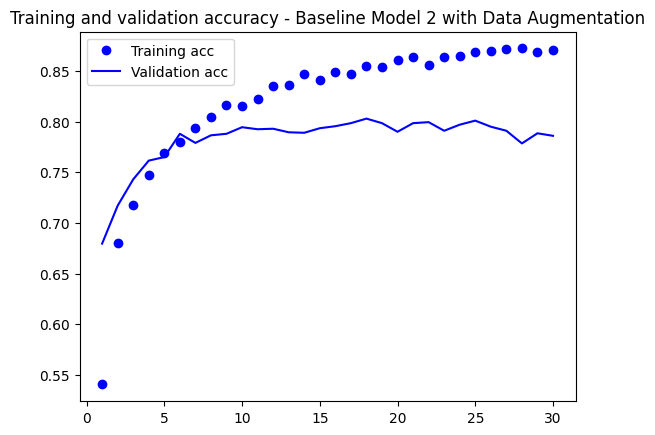

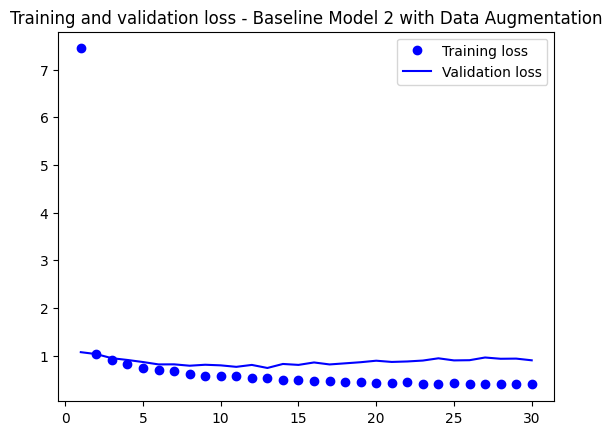

In [76]:
plot_eval_curves(history_2_aug_30, 'Baseline Model 2 with Data Augmentation')

In [77]:
test_loss_m2_aug_30, test_acc_m2_aug_30 = model_2_aug_30.evaluate(test_generator_2, steps=test_generator_2.samples // batch_size)

print(f'Test accuracy: {test_acc_m2_aug_30 * 100:.2f}%')
print(f'Test Loss: {test_loss_m2_aug_30}')

7/7 [==============================] - 1s 133ms/step - loss: 1.0594 - accuracy: 0.7701
Test accuracy: 77.01%
Test Loss: 1.0593661069869995


In [78]:
print (test_generator_2.samples)
print (validation_generator_2.samples)
print (train_generator_2.samples)

print (len(test_generator_2))
print (len(validation_generator_2))
print (len(train_generator_2))

500
2000
7500
8
32
118


#### Model 2 - Feature Extraction with Data Augmentation (Increase # Epochs to 50)

In [79]:
model_2_aug_50 = models.Sequential()

# to prevent any adjustment to the pre-trained weights of vgg16
conv_base.trainable = False

# load in the layers found in vgg16
for layer in conv_base.layers:
    model_2_aug_50.add(layer)
    
model_2_aug_50.add(layers.Flatten())
model_2_aug_50.add(layers.Dense(512, activation='relu'))
model_2_aug_50.add(layers.Dense(num_classes, activation='softmax'))

model_2_aug_50.summary()

# Compile the model
model_2_aug_50.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 37, 37, 256)      

In [80]:
# Train the Model
n_epochs = 50
history_2_aug_50 = model_2_aug_50.fit(
    train_generator_2,
    validation_data = validation_generator_2,
    epochs = n_epochs,
    verbose=1
)

Epoch 1/50
118/118 [==============================] - 48s 401ms/step - loss: 5.2530 - accuracy: 0.5393 - val_loss: 1.2329 - val_accuracy: 0.6690
Epoch 2/50
118/118 [==============================] - 46s 393ms/step - loss: 1.0910 - accuracy: 0.6641 - val_loss: 1.0559 - val_accuracy: 0.7160
Epoch 3/50
118/118 [==============================] - 48s 403ms/step - loss: 0.9239 - accuracy: 0.7147 - val_loss: 0.9701 - val_accuracy: 0.7385
Epoch 4/50
118/118 [==============================] - 46s 392ms/step - loss: 0.8473 - accuracy: 0.7384 - val_loss: 0.9124 - val_accuracy: 0.7520
Epoch 5/50
118/118 [==============================] - 50s 418ms/step - loss: 0.7619 - accuracy: 0.7592 - val_loss: 0.8393 - val_accuracy: 0.7710
Epoch 6/50
118/118 [==============================] - 46s 387ms/step - loss: 0.6880 - accuracy: 0.7845 - val_loss: 0.8318 - val_accuracy: 0.7765
Epoch 7/50
118/118 [==============================] - 47s 393ms/step - loss: 0.6435 - accuracy: 0.7976 - val_loss: 0.8533 - val_ac

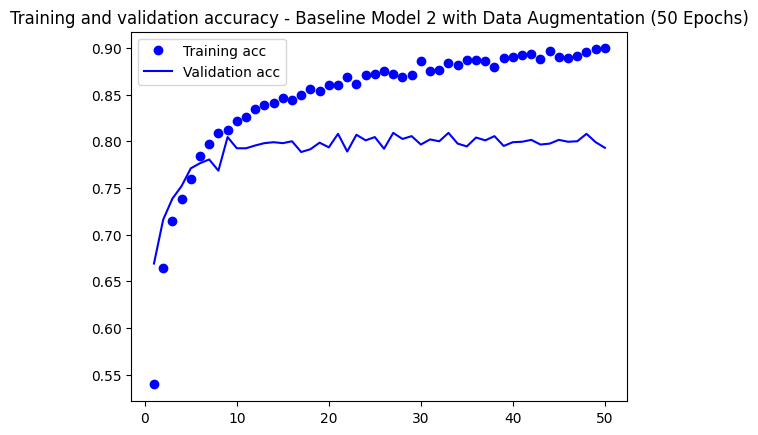

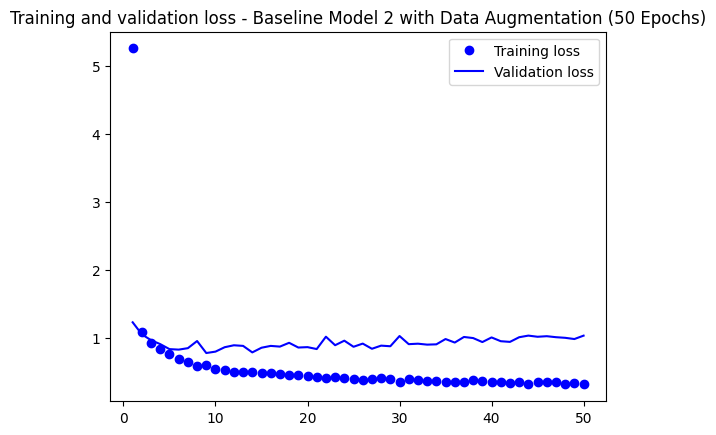

In [81]:
plot_eval_curves(history_2_aug_50, 'Baseline Model 2 with Data Augmentation (50 Epochs)')

In [82]:
test_loss_m2_aug_50, test_acc_m2_aug_50 = model_2_aug_50.evaluate(test_generator_2, steps=test_generator_2.samples // batch_size)

print(f'Test accuracy: {test_acc_m2_aug_50 * 100:.2f}%')
print(f'Test Loss: {test_loss_m2_aug_50}')

7/7 [==============================] - 1s 160ms/step - loss: 1.2010 - accuracy: 0.7790
Test accuracy: 77.90%
Test Loss: 1.200980544090271


#### Model 2 - Feature Extraction with Data Augmentation + Fine Tuning (Epochs = 30) by unfreezing last 3 layers of base network

In [83]:
# from tensorflow.keras import regularizers
# from tensorflow.keras.regularizers import l2
from keras import regularizers
from keras.regularizers import l2

model_2_aug_ft = models.Sequential()

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(img_size, img_size, 3))

# to prevent any adjustment to the pre-trained weights of vgg16
conv_base.trainable = False

# load in the layers found in vgg16
for layer in conv_base.layers:
    model_2_aug_ft.add(layer)
    
model_2_aug_ft.add(layers.Flatten())
model_2_aug_ft.add(layers.Dense(512, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
model_2_aug_ft.add(layers.Dense(num_classes, activation='softmax'))

# check on the convolutional base
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [84]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True # after black5_conv1, set_trainable becomes True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
        
model_2_aug_ft.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 37, 37, 256)     

In [85]:
# Compile the model
model_2_aug_ft.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [86]:
n_epochs = 30
history_2_aug_ft = model_2_aug_ft.fit(
    train_generator_2,
    validation_data = validation_generator_2,
    epochs = n_epochs,
    verbose=1)

Epoch 1/30
118/118 [==============================] - 52s 430ms/step - loss: 3.8242 - accuracy: 0.0933 - val_loss: 3.0500 - val_accuracy: 0.1005
Epoch 2/30
118/118 [==============================] - 50s 420ms/step - loss: 2.9728 - accuracy: 0.0932 - val_loss: 2.9011 - val_accuracy: 0.1000
Epoch 3/30
118/118 [==============================] - 53s 448ms/step - loss: 2.8435 - accuracy: 0.0931 - val_loss: 2.7900 - val_accuracy: 0.1000
Epoch 4/30
118/118 [==============================] - 51s 431ms/step - loss: 2.7457 - accuracy: 0.0937 - val_loss: 2.7041 - val_accuracy: 0.1000
Epoch 5/30
118/118 [==============================] - 51s 433ms/step - loss: 2.6692 - accuracy: 0.0903 - val_loss: 2.6361 - val_accuracy: 0.1000
Epoch 6/30
118/118 [==============================] - 48s 405ms/step - loss: 2.6082 - accuracy: 0.0947 - val_loss: 2.5814 - val_accuracy: 0.1000
Epoch 7/30
118/118 [==============================] - 49s 412ms/step - loss: 2.5588 - accuracy: 0.0899 - val_loss: 2.5369 - val_ac

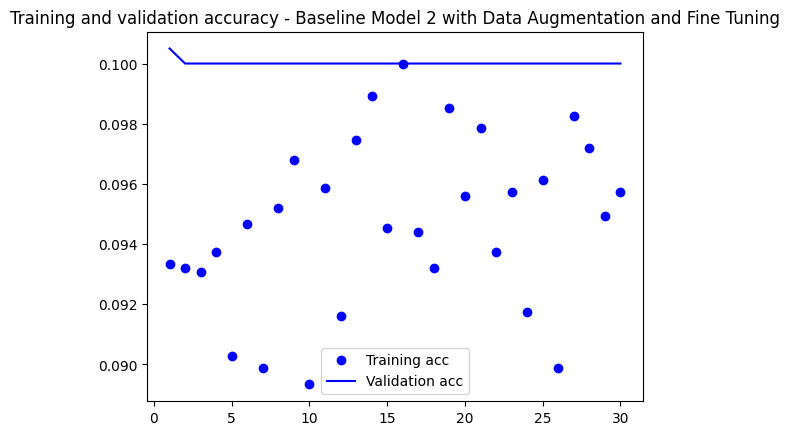

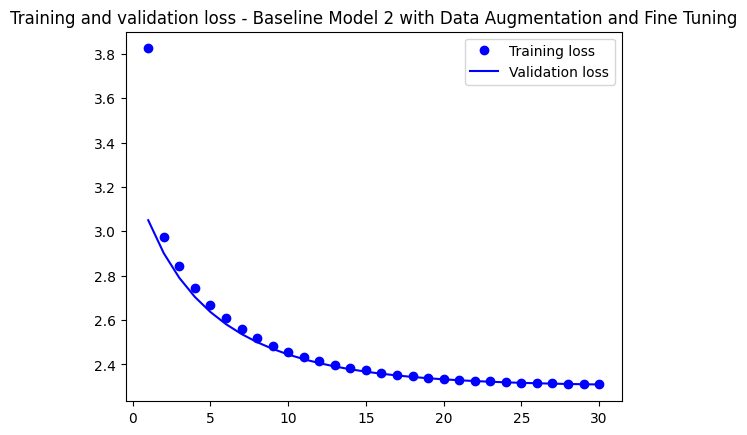

In [87]:
plot_eval_curves(history_2_aug_ft, 'Baseline Model 2 with Data Augmentation and Fine Tuning')

In [88]:
test_loss_m2_aug_30_ft, test_acc_m2_aug_30_ft = model_2_aug_ft.evaluate(test_generator_2, steps=test_generator_2.samples // batch_size)

print(f'Test accuracy: {test_acc_m2_aug_30_ft * 100:.2f}%')
print(f'Test Loss: {test_loss_m2_aug_30_ft}')

7/7 [==============================] - 1s 152ms/step - loss: 2.3095 - accuracy: 0.1004
Test accuracy: 10.04%
Test Loss: 2.30946683883667


#### Model 2 - Feature Extraction with Data Augmentation + Fine Tuning (Epochs = 30) by unfreezing last layer of base network to fix the poor results above

In [89]:
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(img_size, img_size, 3))

model_2_ft = models.Sequential()

# to prevent any adjustment to the pre-trained weights of vgg16
conv_base.trainable = False

# load in the layers found in vgg16
for layer in conv_base.layers:
    model_2_ft.add(layer)
    
model_2_ft.add(layers.Flatten())
# model_2_ft.add(layers.Dense(512, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
model_2_ft.add(layers.Dense(512, activation='relu'))
model_2_ft.add(layers.Dense(num_classes, activation='softmax'))

# check on the convolutional base
conv_base.summary()

conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv3':
        set_trainable = True # after black5_conv1, set_trainable becomes True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
        
model_2_ft.summary()

model_2_ft.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [90]:
n_epochs = 30
history_2_ft = model_2_ft.fit(
    train_generator_2,
    validation_data = validation_generator_2,
    epochs = n_epochs,
    verbose=1)

Epoch 1/30
118/118 [==============================] - 54s 451ms/step - loss: 4.0874 - accuracy: 0.4484 - val_loss: 1.4207 - val_accuracy: 0.6035
Epoch 2/30
118/118 [==============================] - 50s 423ms/step - loss: 1.3211 - accuracy: 0.6292 - val_loss: 1.2713 - val_accuracy: 0.6755
Epoch 3/30
118/118 [==============================] - 50s 422ms/step - loss: 1.1184 - accuracy: 0.6941 - val_loss: 1.0022 - val_accuracy: 0.7460
Epoch 4/30
118/118 [==============================] - 47s 400ms/step - loss: 1.0313 - accuracy: 0.7233 - val_loss: 1.0129 - val_accuracy: 0.7500
Epoch 5/30
118/118 [==============================] - 48s 402ms/step - loss: 0.8666 - accuracy: 0.7663 - val_loss: 1.0565 - val_accuracy: 0.7465
Epoch 6/30
118/118 [==============================] - 47s 395ms/step - loss: 0.7919 - accuracy: 0.7841 - val_loss: 0.8201 - val_accuracy: 0.7890
Epoch 7/30
118/118 [==============================] - 47s 401ms/step - loss: 0.7641 - accuracy: 0.7896 - val_loss: 0.8386 - val_ac

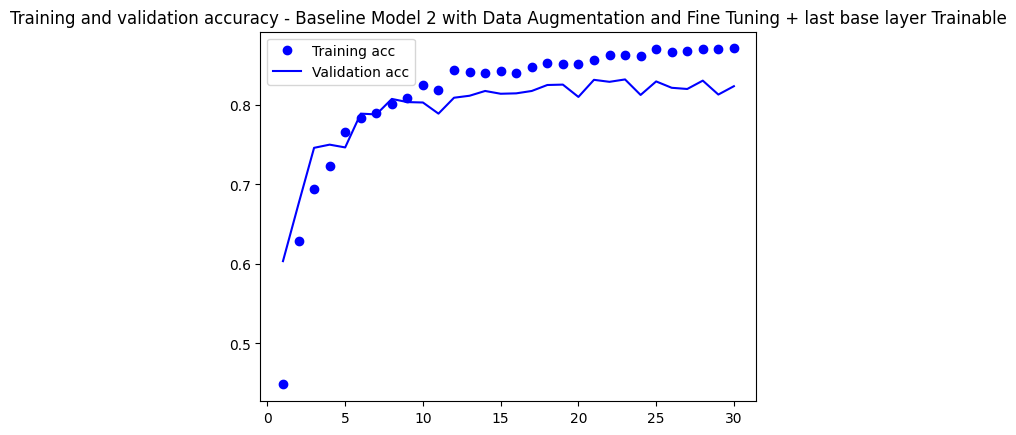

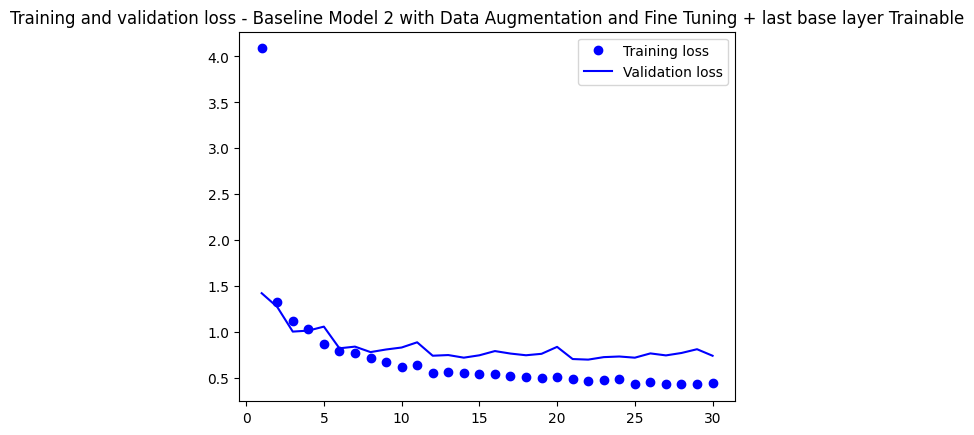

In [91]:
# Print the trainable layers
# for layer in model_2_aug_ft.layers:
#     print (layer.name + ' ' + str(layer.trainable))
    
plot_eval_curves(history_2_ft, 'Baseline Model 2 with Data Augmentation and Fine Tuning + last base layer Trainable')

In [92]:
test_loss_m2_aug_30_ft_last, test_acc_m2_aug_30_ft_last = model_2_ft.evaluate(test_generator_2, steps=test_generator_2.samples // batch_size)

print(f'Test accuracy: {test_acc_m2_aug_30_ft_last * 100:.2f}%')
print(f'Test Loss: {test_loss_m2_aug_30_ft_last}')

7/7 [==============================] - 1s 129ms/step - loss: 0.8574 - accuracy: 0.8170
Test accuracy: 81.70%
Test Loss: 0.8574236631393433


In [95]:
# Example data: each experiment has a test loss and test accuracy
m2_experiment_results = [
    {"experiment": "Exp1", "test_loss": test_loss_m2_no_aug, "test_acc": test_acc_m2_no_aug},
    {"experiment": "Exp2", "test_loss": test_loss_m2_aug_30, "test_acc": test_acc_m2_aug_30},
    {"experiment": "Exp3", "test_loss": test_loss_m2_aug_50, "test_acc": test_acc_m2_aug_50},
    {"experiment": "Exp4", "test_loss": test_loss_m2_aug_30_ft, "test_acc": test_acc_m2_aug_30_ft},
    {"experiment": "Exp5", "test_loss": test_loss_m2_aug_30_ft_last, "test_acc": test_acc_m2_aug_30_ft_last}   
]

# Create a DataFrame
m2_df = pd.DataFrame(m2_experiment_results)

# Round the entire DataFrame to 2 decimal places
m2_df = m2_df.round({"test_loss": 2, "test_acc": 2})

display(m2_df)

# Optionally, if you want to find the best experiment
best_by_acc = m2_df.loc[m2_df['test_acc'].idxmax()]
best_by_loss = m2_df.loc[m2_df['test_loss'].idxmin()]
print("\nBest by accuracy:", best_by_acc, '\n')
print("\nBest by loss:", best_by_loss, '\n')

experiment  test_loss  test_acc
0       Exp1       1.31      0.77
1       Exp2       1.06      0.77
2       Exp3       1.20      0.78
3       Exp4       2.31      0.10
4       Exp5       0.86      0.82


Best by accuracy: experiment    Exp5
test_loss     0.86
test_acc      0.82
Name: 4, dtype: object 


Best by loss: experiment    Exp5
test_loss     0.86
test_acc      0.82
Name: 4, dtype: object 



In [93]:
import time
# Save the Model
model_2_no_aug.save(datetime.datetime.now().strftime('%d-%m-%y-%H_%M_food_model_2_a.keras'))
# time.sleep(30)
model_2_aug_30.save(datetime.datetime.now().strftime('%d-%m-%y-%H_%M_food_model_2_b.keras'))
# time.sleep(30)
model_2_aug_50.save(datetime.datetime.now().strftime('%d-%m-%y-%H_%M_food_model_2_c.keras'))
# time.sleep(30)
model_2_aug_ft.save(datetime.datetime.now().strftime('%d-%m-%y-%H_%M_food_model_2_d.keras'))
# time.sleep(30)
model_2_ft.save(datetime.datetime.now().strftime('%d-%m-%y-%H_%M_food_model_2_e.keras'))

## Step 3 – Evaluate the Developed Models using Testing Images

In [96]:
# Model #1
model_11 = keras.models.load_model('17-11-24-15_05_food_model_1_bl_20.keras')

test_loss_m11, test_acc_m11 = model_11.evaluate(test_generator_1, steps=test_generator_1.samples // batch_size)

print(f'Test accuracy: {test_acc_m11 * 100:.2f}%')
print(f'Test Loss: {test_loss_m11}')

7/7 [==============================] - 1s 99ms/step - loss: 0.9791 - accuracy: 0.6719
Test accuracy: 67.19%
Test Loss: 0.9791046380996704


In [97]:
# Model #2
model_22 = keras.models.load_model('17-11-24-17_50_food_model_2_e.keras')

test_loss_m22, test_acc_m22 = model_22.evaluate(test_generator_2, steps=test_generator_2.samples // batch_size)

print(f'Test accuracy: {test_acc_m22 * 100:.2f}%')
print(f'Test Loss: {test_loss_m22}')

7/7 [==============================] - 1s 122ms/step - loss: 0.8161 - accuracy: 0.8170
Test accuracy: 81.70%
Test Loss: 0.8161494135856628


In [106]:
# Example data: each experiment has a test loss and test accuracy
m1_vs_m2_experiment_results = [
    {"experiment": "Model 1 - Best", "test_loss": test_loss_m11, "test_acc": test_acc_m11},
    {"experiment": "Model 2 - Best", "test_loss": test_loss_m22, "test_acc": test_acc_m22}    
]

# Create a DataFrame
m1_vs_m2_df = pd.DataFrame(m1_vs_m2_experiment_results)

# Round the entire DataFrame to 2 decimal places
m1_vs_m2_df = m1_vs_m2_df.round({"test_loss": 2, "test_acc": 2})

display(m1_vs_m2_df)

# Optionally, if you want to find the best experiment
best_by_acc = m1_vs_m2_df.loc[m1_vs_m2_df['test_acc'].idxmax()]
best_by_loss = m1_vs_m2_df.loc[m1_vs_m2_df['test_loss'].idxmin()]
print("\nBest by accuracy:", best_by_acc, '\n')
print("\nBest by loss:", best_by_loss, '\n')

experiment  test_loss  test_acc
0  Model 1 - Best       0.98      0.67
1  Model 2 - Best       0.82      0.82


Best by accuracy: experiment    Model 2 - Best
test_loss               0.82
test_acc                0.82
Name: 1, dtype: object 


Best by loss: experiment    Model 2 - Best
test_loss               0.82
test_acc                0.82
Name: 1, dtype: object 



In [98]:
# Save the best model
filename_best = datetime.datetime.now().strftime('%d-%m-%y-%H_%M_food_model_best.keras')
model_22.save(filename_best)

## Step 4  – Use the best model to make prediction

In [99]:
# Load the model
model_best = keras.models.load_model('17-11-24-18_19_food_model_best.keras')

In [100]:
# Load the food list (in alphabetical order)
with open('food_list.txt', 'r') as f:
    x = f.readlines()
food_list =[]
for item in x:
    food_list.append(item.strip('\n'))
food_list = sorted(food_list) # food_list needs to be sorted alphabetically before feed into prediction() function
print(food_list)

['baby_back_ribs', 'bibimbap', 'cup_cakes', 'dumplings', 'fried_calamari', 'garlic_bread', 'lasagna', 'pancakes', 'prime_rib', 'tiramisu']


In [101]:
# Define some related functions for image process and model prediction
from tensorflow.keras.preprocessing.image import load_img, img_to_array
def image_process(img):
    image = load_img(img, target_size =(img_size, img_size))
    image_array = img_to_array(image)/255
    return image_array

import pandas as pd
def prediction(model, img_array, items_l):
    prob = model.predict(img_array.reshape(1,img_size,img_size,3))
    pro_df = pd.DataFrame(prob, columns = items_l)
    result = items_l[np.argmax(prob)]
    return pro_df, result

1/1 [==============================] - 1s 1s/step


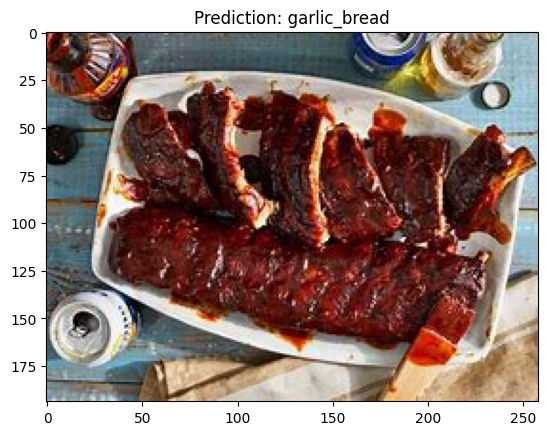

1/1 [==============================] - 0s 20ms/step


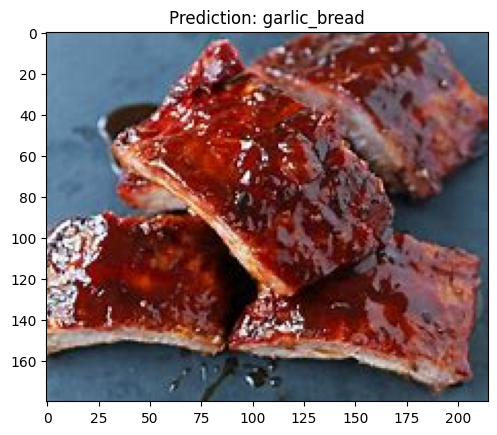

1/1 [==============================] - 0s 23ms/step


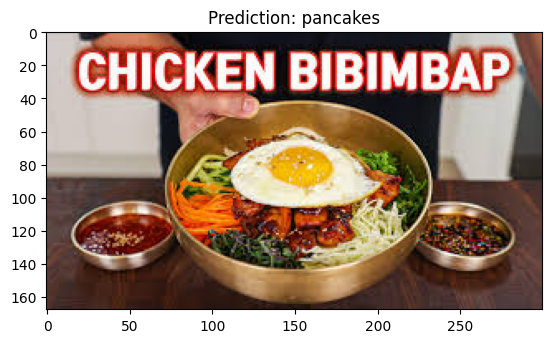

1/1 [==============================] - 0s 20ms/step


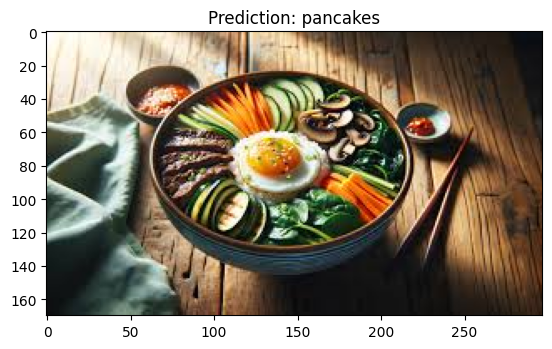

1/1 [==============================] - 0s 23ms/step


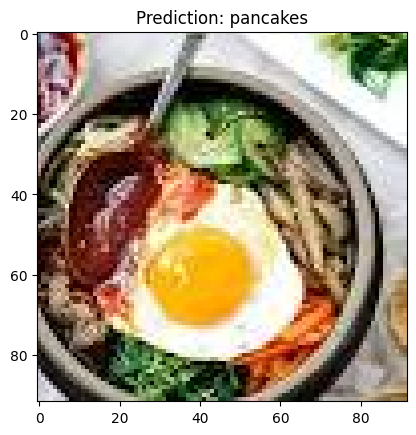

1/1 [==============================] - 0s 17ms/step


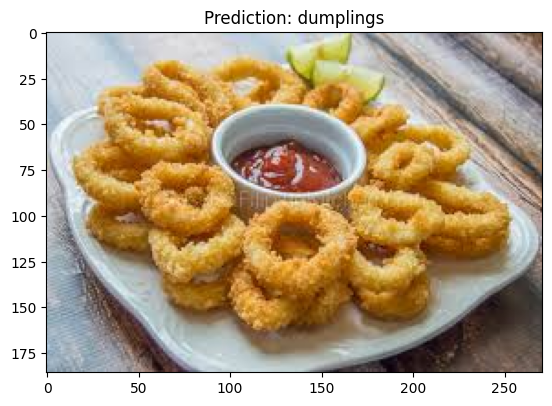

1/1 [==============================] - 0s 18ms/step


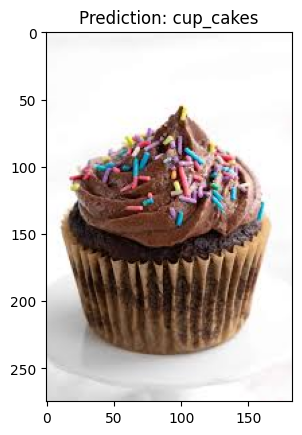

1/1 [==============================] - 0s 17ms/step


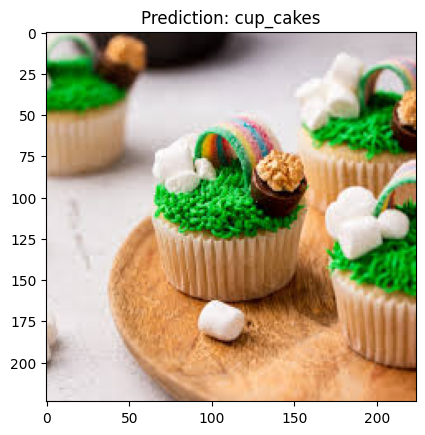

1/1 [==============================] - 0s 20ms/step


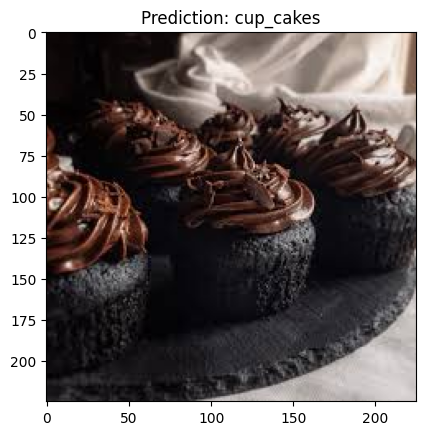

1/1 [==============================] - 0s 21ms/step


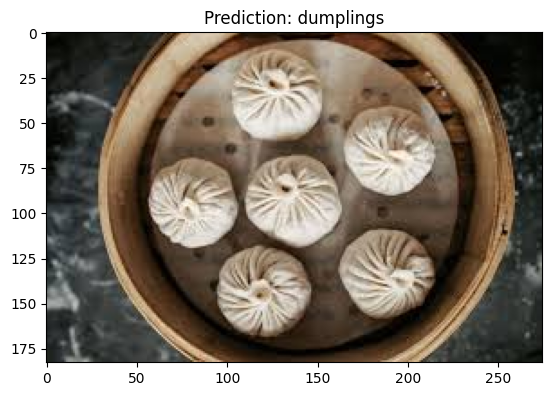

1/1 [==============================] - 0s 17ms/step


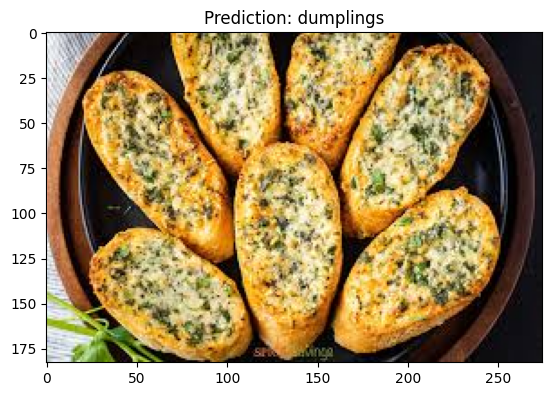

1/1 [==============================] - 0s 19ms/step


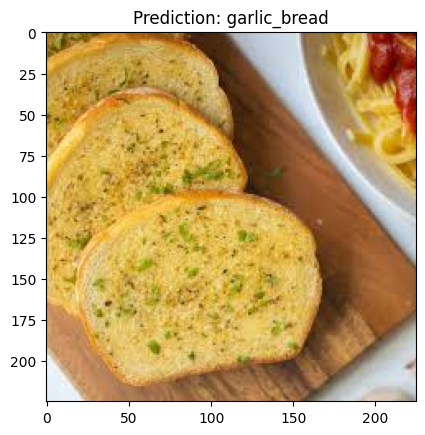

1/1 [==============================] - 0s 19ms/step


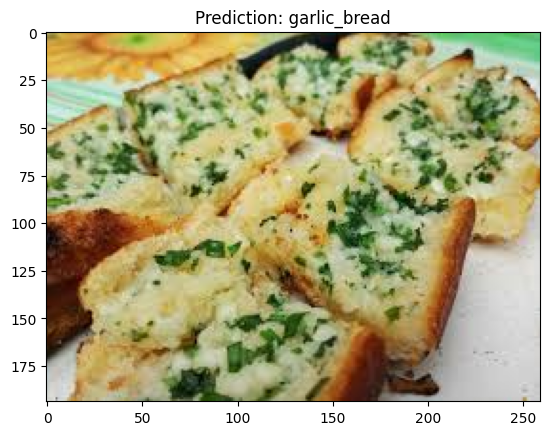

1/1 [==============================] - 0s 18ms/step


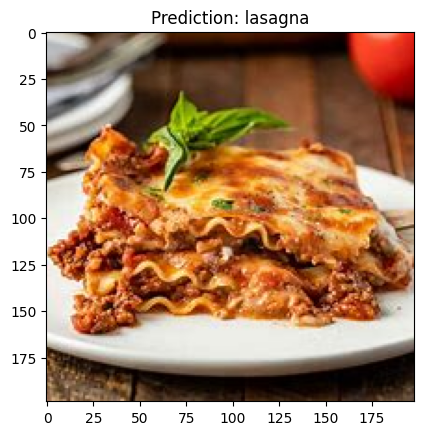

1/1 [==============================] - 0s 16ms/step


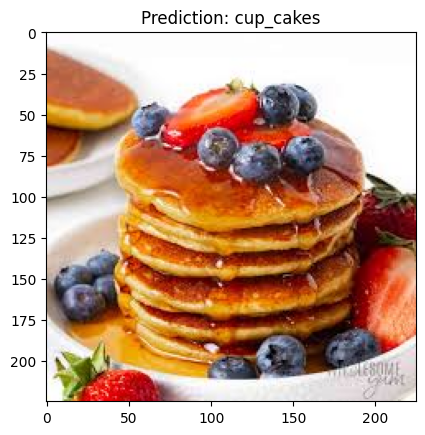

1/1 [==============================] - 0s 18ms/step


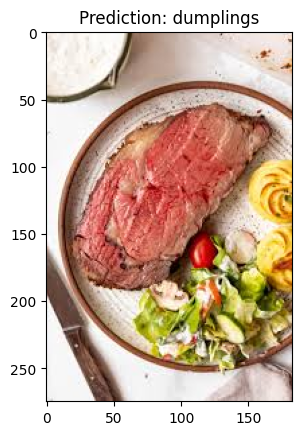

1/1 [==============================] - 0s 18ms/step


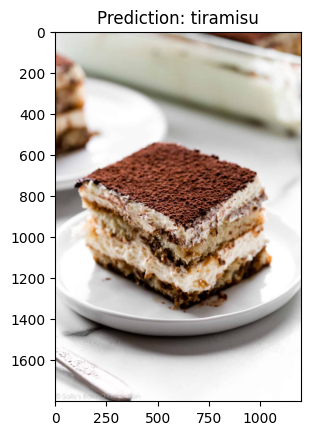

In [102]:
from tensorflow.keras.preprocessing import image

# Directory containing the test images
test_dir = 'Test_Data\\'

def predict_from_model(model, dir):
    # Loop through each image in the test directory
    for img_name in os.listdir(test_dir):
        img_path = os.path.join(test_dir, img_name)

        # Load and preprocess image
        img_array = image_process(img_path)

        # Make prediction
        prob_df, result = prediction(model, img_array, food_list)

        # Display image
        img = image.load_img(img_path)
        plt.imshow(img)
        plt.title(f'Prediction: {result}')
        plt.show()

        # print('The prediction is: ', result, '\n\n', prob_df)
        # print('The prediction probability distribution is: \n', prob_df, '\n\n')
        
        # This function from IPython.display allows you to display a DataFrame nicely within a Jupyter Notebook.
        # Use .style.highlight_max(axis=1) to highlight the maximum probability for each row.
        # When you run predict_from_model, it will display each image alongside a nicely formatted DataFrame 
        # showing the prediction probabilities, with the highest probability highlighted
        display(prob_df.style.highlight_max(axis=1))
        
predict_from_model(model_best, test_dir)

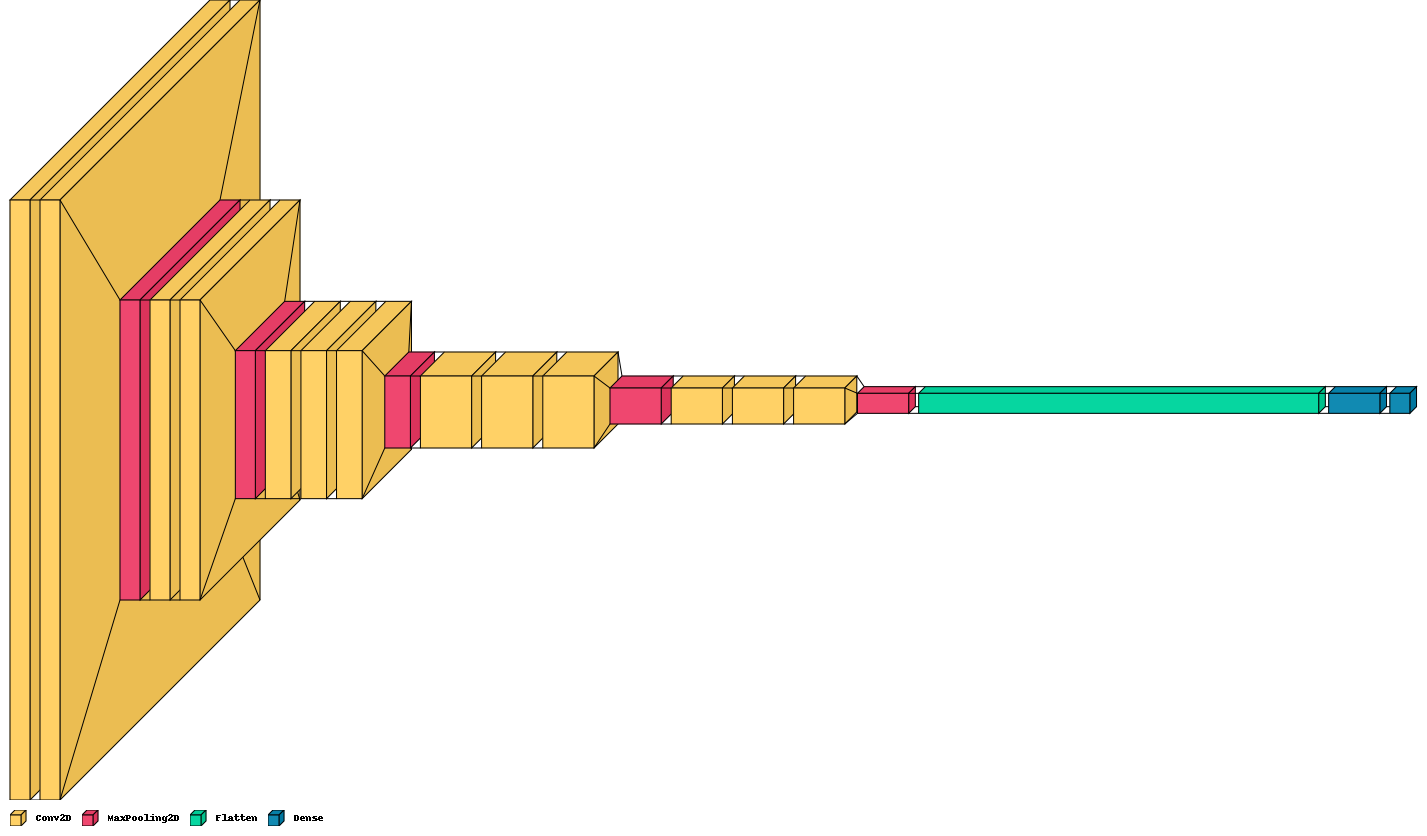

In [103]:
visualkeras.layered_view(model_22, legend=True, to_file='pretrained_base_model_2_best.png')
visualkeras.layered_view(model_22, legend=True)

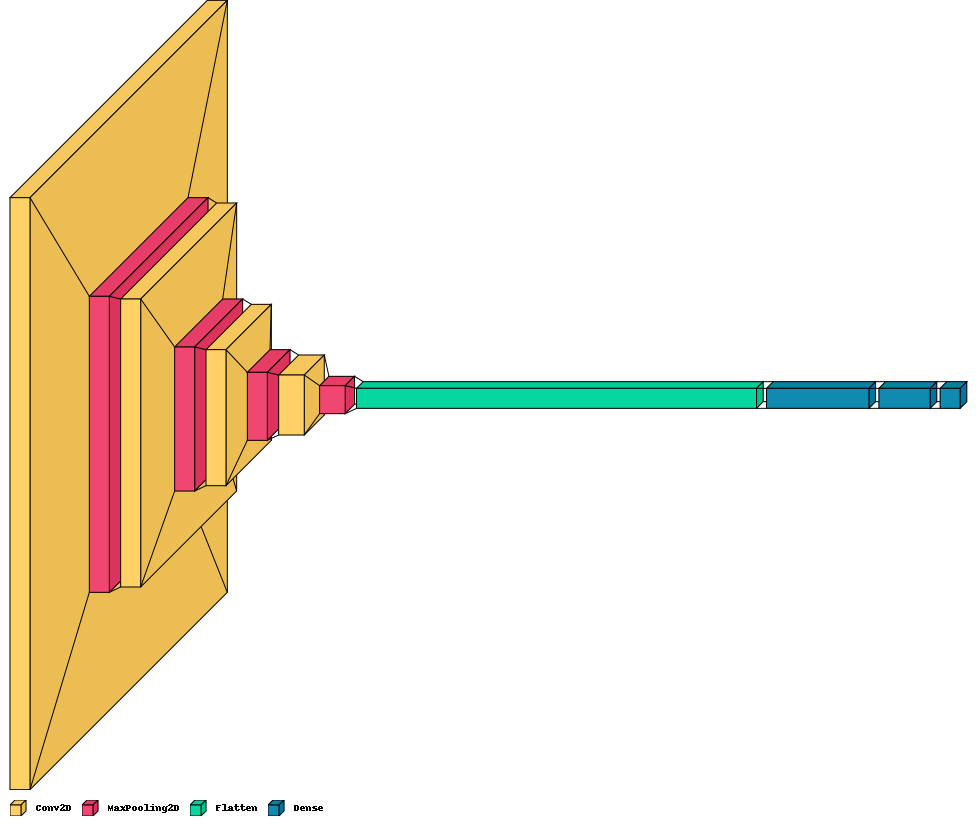

In [104]:
visualkeras.layered_view(model_11, legend=True, to_file='custom_model_1_best.png')
visualkeras.layered_view(model_11, legend=True)

In [ ]:
# https://stackoverflow.com/questions/78145837/importerror-cannot-import-name-imagedatagenerator-from-keras-preprocessing-i
# from keras.src.legacy.preprocessing.image import ImageDataGenerator
# If running on newer versions of tensorflow/keras